# I/ General zone

'''
Combine columns skills
Make sure type of data
Translations
Merging 
'''

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
## Import neccessary packages
import pandas as pd
from csv import reader
import numpy as np
import re
import os

## Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

import seaborn as sns
# from wordcloud import WordCloud, STOPWORDS

# Date time conversion registration
from pandas.plotting import register_matplotlib_converters
from dateutil import parser


Matplotlib is building the font cache; this may take a moment.


In [6]:
## Read the dataset
pd.set_option('display.max_rows',1500)
## For Company computer
# job_df = pd.read_csv("C:/Users/Vincent Kwok/Documents/Quách Đại Vinh/Work/Saigon AI/Side_project/data_1971_resubgroup.csv")
job_df = pd.read_csv("/Users/vinh/Documents/Work/Side-Project/data_1971_resubgroup.csv")

# II/ Overview of the dataset

<Axes: >

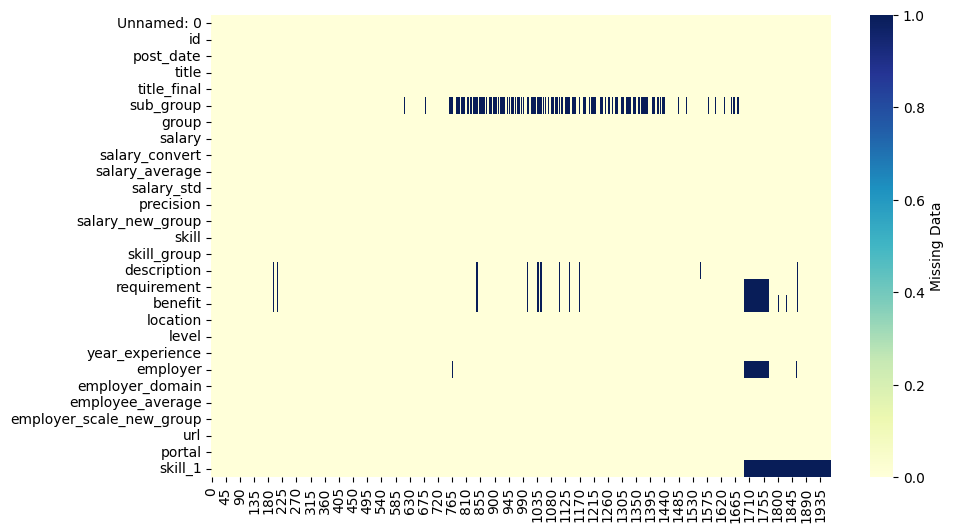

In [7]:
## Checking Missing Value

## Variable name in x axis
# Show the missing values of each column
# sns.heatmap(it_job.isnull(),\
#             # yticklabels=False,cbar=False,cmap="blue"
#             )

## Variable name in y axis
plt.figure(figsize=(10,6))
sns.heatmap(job_df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

# III/ Analysis Area

## 1/ General function

In [8]:
def to_str(s):   
    """ Convert data to string """
    return str(s)

In [9]:
def to_float(row):
  """ Convert data to float """
  try:
    row = float(row)
  except:
    row = row
  return row

In [10]:
def replace_all(text, dic):
    """
    This function replace words in key by their values in the dictionary
    text: sentence to translate
    dic: dictionary of keywords need to be replaced and their replaced words
    """
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

In [11]:
## Replace words in job title
to_replace = {"back end": "backend",
            "front end": "frontend",
            "full stack": "fullstack",
            "it": "",
            "experience": "",
            "data analysis": "data analyst",
            "business analysts":"business analyst",
            "ho ":"",
            "data analytics": "data analyst",
            "hadoop":""}
job_df["title_final"] = job_df["title_final"].apply(lambda x: replace_all(x,to_replace))


In [12]:
## Remove redundant jobsjobs
job_df_new = job_df[~(job_df["sub_group"].isnull())].reset_index()

In [214]:
### Color for visualization 
## Navy for the first title, teal for the second title, organe for the third title, orangered for the fourth title
dev_color = ['Navy','teal','orange','orangered']
data_color = ['Navy','teal','orange','orangered']

In [14]:
## Adjusting the display space
pd.set_option('display.max_rows',1500)
# job_df_new[['salary_convert','min_salary','max_salary']]

## 2/ Salary Column


In [13]:
## Adjust undefined data in min and max salary
job_df_new['min_salary'] = np.NaN
job_df_new['max_salary'] = np.NaN

for i in range(len(job_df_new)):
    
    if (float(job_df_new['salary_convert'][i].split('-')[0]) == 0):
        job_df_new['min_salary'][i] = job_df_new['salary_convert'][i].split('-')[1]
        job_df_new['max_salary'][i] = job_df_new['salary_convert'][i].split('-')[1]
    
    elif (float(job_df_new['salary_convert'][i].split('-')[1]) == 9999999999):
        job_df_new['min_salary'][i] = job_df_new['salary_convert'][i].split('-')[0]
        job_df_new['max_salary'][i] = job_df_new['salary_convert'][i].split('-')[0]
    
    else: 
        job_df_new['min_salary'][i] = job_df_new['salary_convert'][i].split('-')[0]
        job_df_new['max_salary'][i] = job_df_new['salary_convert'][i].split('-')[1]

In [211]:
## Remove unqualified data
salary_data = job_df_new[~(job_df_new['salary'].str.contains('100 - 200 IDR'))].reset_index()
salary_data = salary_data[~(salary_data['salary_average'] == 1)]

In [212]:
## Finalized a new range of data
salary_data_range = salary_data[~((salary_data['salary_convert'].str.contains('999999')) | (salary_data['salary_convert'].str.startswith('0.0')))]

### Sal <> Title_final

In [18]:
## Select neccesary columns
sal_title = salary_data[["id","salary_average","sub_group",'salary_convert']]

In [19]:
## Calculating the average salary of each sub-group
regroup_title_sal = sal_title\
.groupby(["sub_group"])\
.agg({"salary_average":"mean"
      })\
.reset_index()

In [20]:
## Calculating the salary range of each sub_group
std_sal_title = sal_title.groupby(["sub_group"])['salary_average'].std().dropna().to_frame().reset_index()
data_with_std = regroup_title_sal.merge(std_sal_title,on="sub_group",how="left")
data_with_std["min"] = data_with_std["salary_average_x"] - data_with_std["salary_average_y"]
data_with_std["max"] = data_with_std["salary_average_x"] + data_with_std["salary_average_y"] 

In [21]:
## Review the data
data_with_std.sort_values('salary_average_x',ascending= False)

sub_group  salary_average_x  salary_average_y          min          max
3   DS/ML/AI       1726.175000        848.471959   877.703041  2574.646959
2         DE       1689.255102        609.075992  1080.179110  2298.331094
6  fullstack       1497.082218        645.899783   851.182434  2142.982001
4    backend       1471.691064        642.219967   829.471097  2113.911031
7     mobile       1449.701005        714.385647   735.315358  2164.086653
5   frontend       1433.661111        730.461868   703.199243  2164.122979
1      DA/BI       1239.870616        753.934609   485.936006  1993.805225
0         BA       1203.120714        502.237594   700.883120  1705.358309

In [22]:
### Stack dataset in which one row for min and one row for max for each sub group
df_metled = pd.melt(data_with_std, id_vars = ['sub_group'], value_vars =['min', 'max'])

## Detach the dataset into data and IT group
df_metled_data = df_metled[df_metled['sub_group'].isin(['BA','DA/BI','DE','DS/ML/AI'])].reset_index()
df_metled_dev = df_metled[~(df_metled['sub_group'].isin(['BA','DA/BI','DE','DS/ML/AI']))].reset_inde()

<function matplotlib.pyplot.show(close=None, block=None)>

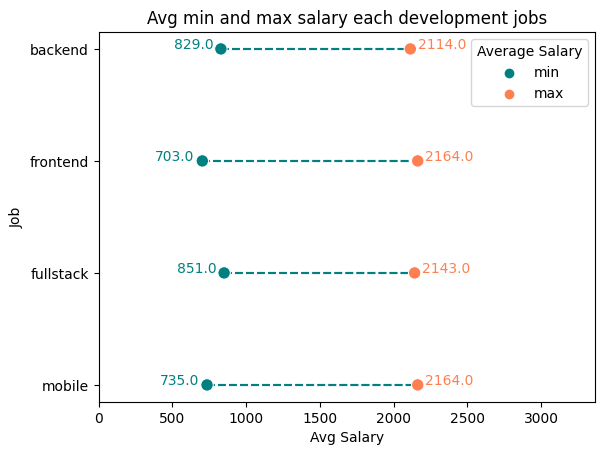

In [209]:
### Visualization between sub group and salary for IT group
df_metled_dev['value'] = df_metled_dev['value'].apply(lambda x:round(x,0))
sns.scatterplot(df_metled_dev,x='value',y='sub_group',
                hue='variable',s=80,palette=['teal','coral'])
for n in df_metled_dev['sub_group']:
  plt.hlines(n, df_metled_dev[(df_metled_dev['sub_group'] == n)&(df_metled_dev['variable'] == 'min')]['value'], 
             df_metled_dev[(df_metled_dev['sub_group'] == n)&(df_metled_dev['variable'] == 'max')]['value'],
             ls='--',color='teal',zorder=0)
for i in range(df_metled_dev.shape[0]):
      if df_metled_dev['variable'][i] == 'min':
            plt.text(x=df_metled_dev.value[i]-320,y=df_metled_dev.sub_group[i],s=df_metled_dev.value[i], 
          fontdict=dict(color='teal',size=10))
      else: plt.text(x=df_metled_dev.value[i]+50,y=df_metled_dev.sub_group[i],s=df_metled_dev.value[i], 
          fontdict=dict(color='coral',size=10))
plt.xlim(0,df_metled_dev['value'].max()+1200)
plt.legend(title="Average Salary")
plt.xlabel('Avg Salary')
plt.ylabel('Job')
plt.title('Avg min and max salary each development jobs')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

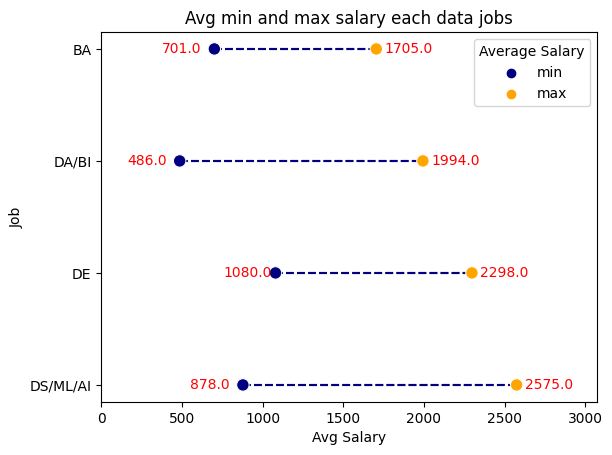

In [205]:
### Visualization between sub group and salary for Data group
df_metled_data['value'] = df_metled_data['value'].apply(lambda x:round(x,0))
sns.scatterplot(df_metled_data,x='value',y='sub_group',hue='variable',
                s=80,palette=['Navy','orange'])
for n in df_metled_data['sub_group']:
  plt.hlines(n, df_metled_data[(df_metled_data['sub_group'] == n)&(df_metled_data['variable'] == 'min')]['value'], 
             df_metled_data[(df_metled_data['sub_group'] == n)&(df_metled_data['variable'] == 'max')]['value'],
             ls='--',color='Navy',zorder=0)
for i in range(df_metled_data.shape[0]):
      if df_metled_dev['variable'][i] == 'min':
            plt.text(x=df_metled_data.value[i]-325,y=df_metled_data.sub_group[i],s=df_metled_data.value[i],ha = 'left', va = 'center',
          fontdict=dict(color='red',size=10))
      else: plt.text(x=df_metled_data.value[i]+50,y=df_metled_data.sub_group[i],s=df_metled_data.value[i], ha = 'left', va = 'center',
          fontdict=dict(color='red',size=10))
plt.xlim(0,df_metled_data['value'].max()+500)
plt.legend(title="Average Salary")
plt.xlabel('Avg Salary')
plt.ylabel('Job')
plt.title('Avg min and max salary each data jobs')
plt.show

### Sal <> Job_group

##### General

In [25]:
# visualize the number of value inside each group
# Calculate number of data in each group
sal_group_cout = pd.DataFrame(salary_data["salary_new_group"].value_counts().reset_index())
sal_group_cout.rename(columns = {'index':'group','new_group':'counting'}, inplace = True)

In [26]:
## reorder the position of each group
t = pd.CategoricalDtype(categories=["0-1000","1001-1500","1501-2000","2001-2500","2501-3000",">3000"], ordered=True)
sal_group_cout['group'] = pd.Series(sal_group_cout.group, dtype=t)
sal_group_cout.sort_values(by=['group'], inplace=True)

Text(0, 0.5, 'Frequency')

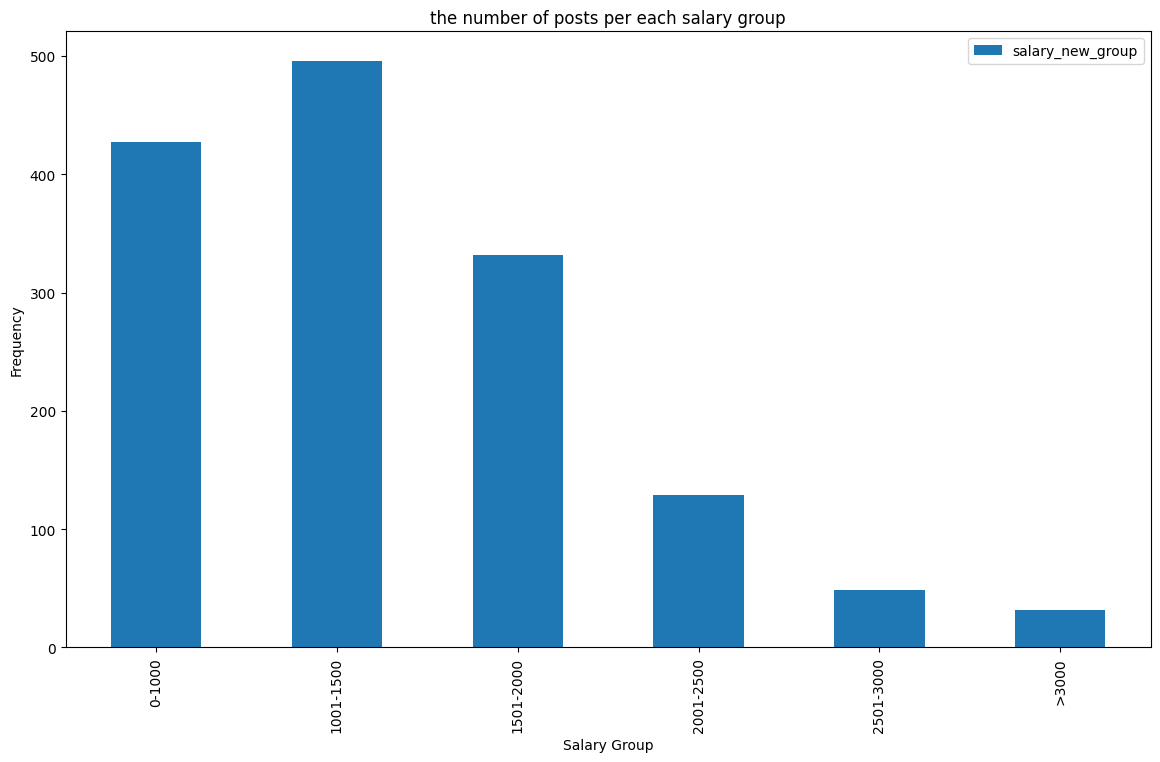

In [27]:
# plotting the chart
Salary_graph = sal_group_cout.set_index("group").plot(kind='bar',
                                    figsize=(14,8),
                                    title="the number of posts per each salary group")
Salary_graph.set_xlabel("Salary Group")
Salary_graph.set_ylabel("Frequency")

##### Per group

In [28]:
## Counting unique values for each salary group and job sub group
sal_group_count = salary_data[["salary_new_group",'sub_group']].value_counts().reset_index()
sal_group_count.rename(columns = {0:'counting'}, inplace = True)

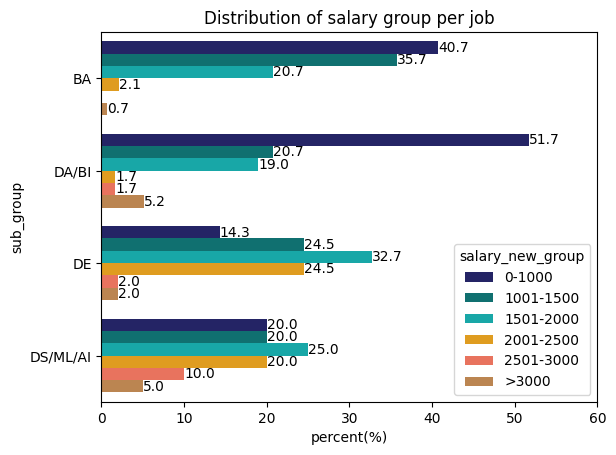

In [202]:
### Visualization between sub group and salary for Data group
sal_group_count_data = sal_group_count[~(sal_group_count['sub_group'].isin(['mobile','fullstack','frontend','backend']))]
sal_group_count_data_to_chart = pd.DataFrame(columns=['salary_new_group','sub_group','counting','percent'])
for i in ['BA', 'DA/BI', 'DE', 'DS/ML/AI']:
    dataset_ = sal_group_count_data[sal_group_count_data['sub_group'] == i]
    dataset_['percent'] = round((dataset_['counting']/sum(dataset_['counting']))*100,1)
    sal_group_count_data_to_chart = pd.concat([sal_group_count_data_to_chart,dataset_],axis=0)
ax = sns.barplot(sal_group_count_data_to_chart,x='percent',y='sub_group',
                hue='salary_new_group',
                palette=['midnightblue','teal','c','orange','tomato','peru'],
                order = ['BA', 'DA/BI', 'DE', 'DS/ML/AI'],
                hue_order=["0-1000","1001-1500","1501-2000","2001-2500","2501-3000",">3000"])
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f')
plt.title('Distribution of salary group per job')
plt.xlabel('percent(%)')
plt.xlim(0,60)
plt.show()

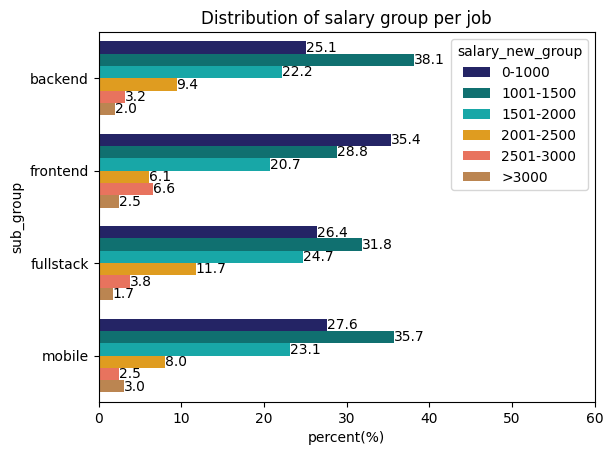

In [116]:
### Visualization between sub group and salary for IT group
sal_group_count_dev = sal_group_count[sal_group_count['sub_group'].isin(['mobile','fullstack','frontend','backend'])]
sal_group_count_dev_to_chart = pd.DataFrame(columns=['salary_new_group','sub_group','counting','percent'])
for i in ['mobile','fullstack','frontend','backend']:
    dataset_ = sal_group_count_dev[sal_group_count_dev['sub_group'] == i]
    dataset_['percent'] = round((dataset_['counting']/sum(dataset_['counting']))*100,1)
    sal_group_count_dev_to_chart = pd.concat([sal_group_count_dev_to_chart,dataset_],axis=0)
ax = sns.barplot(sal_group_count_dev_to_chart,x='percent',y='sub_group',hue='salary_new_group',
                palette=['midnightblue','teal','c','orange','tomato','peru'],
                order = ['backend','frontend','fullstack','mobile'],
                hue_order=["0-1000","1001-1500","1501-2000","2001-2500","2501-3000",">3000"])
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f')                
plt.title('Distribution of salary group per job')
plt.xlabel('percent(%)')
plt.xlim(0,60)
plt.show()

### Sal <> scale

In [31]:
## Split each employer scale vs salary average
job_df_sal_scale = salary_data[["id","salary_average","employer_scale_new_group",'sub_group']]
job_df_sal_scale.employer_scale_new_group = job_df_sal_scale.employer_scale_new_group.str.split(',')                                                               
job_df_sal_scale = job_df_sal_scale.explode('employer_scale_new_group')
job_df_sal_scale = job_df_sal_scale.reset_index()
job_df_sal_scale = job_df_sal_scale[~(job_df_sal_scale['employer_scale_new_group'] == 'nodata')]

In [32]:
## Calculating the average salary for each employer scale
the_regroup_scale = job_df_sal_scale\
.groupby(["employer_scale_new_group",'sub_group'])\
.agg({"salary_average":"mean"})\
.reset_index()

In [242]:
## Review the dataset
the_regroup_scale[the_regroup_scale['sub_group'].isin(['backend','frontend','fullstack','mobile'])]

employer_scale_new_group  sub_group  salary_average
0                      0-10    backend     2060.625000
1                      0-10   frontend     1591.333333
2                      0-10  fullstack     1613.000000
3                      0-10     mobile     1598.333333
8                     10-99    backend     1403.203671
9                     10-99   frontend     1398.645133
10                    10-99  fullstack     1401.829365
11                    10-99     mobile     1413.161905
16                  100-299    backend     1542.874863
17                  100-299   frontend     1447.877193
18                  100-299  fullstack     1690.264375
19                  100-299     mobile     1412.576271
24                 300-4999    backend     1561.381944
25                 300-4999   frontend     1528.026316
26                 300-4999  fullstack     1358.291667
27                 300-4999     mobile     1668.000000
32                    >5000    backend     1396.656250
33                    >5000   frontend     1394.166667
34                    >5000  fullstack     1346.666667
35                    >5000     mobile      967.500000

In [238]:
## Counting the number of each employer scale for each sub group
counting_chart = job_df_sal_scale[['employer_scale_new_group','sub_group']].value_counts().to_frame().reset_index().rename({0:'count'},axis=1)
scale_sal_final = the_regroup_scale.merge(counting_chart,on=['sub_group','employer_scale_new_group'],how='inner')

In [34]:
## Detached the dataset into 2 small dataset one for dev and one for data
scale_sal_final_dev = scale_sal_final[scale_sal_final['sub_group'].isin(['mobile','fullstack','frontend','backend'])].reset_index().drop(['index'],axis=1)
scale_sal_final_data = scale_sal_final[~(scale_sal_final['sub_group'].isin(['mobile','fullstack','frontend','backend']))].reset_index().drop(['index'],axis=1)

In [35]:
## Adding missing groups in Dev and Data groupsgroups
for i in set(scale_sal_final_dev['sub_group']):
    test = scale_sal_final_dev[scale_sal_final_dev['sub_group'] == i]
    for n in ['0-10', '10-99', '100-299', '300-4999', '>5000']:
        if n not in list(set(test['employer_scale_new_group'])):
                new_row = {'employer_scale_new_group':n,'sub_group':i, 'salary_average':0, 'count':0}
                scale_sal_final_dev = scale_sal_final_dev.append(new_row, ignore_index=True)


for i in set(scale_sal_final_data['sub_group']):
    test = scale_sal_final_data[scale_sal_final_data['sub_group'] == i]
    for n in ['0-10', '10-99', '100-299', '300-4999', '>5000']:
        if n not in list(set(test['employer_scale_new_group'])):
                new_row = {'employer_scale_new_group':n,'sub_group':i, 'salary_average':0, 'count':0}
                scale_sal_final_data = scale_sal_final_data.append(new_row, ignore_index=True)

In [36]:
## Sorting the texting starting from smallest group to the highest group
sorter = ['0-10', '10-99', '100-299', '300-4999', '>5000']
scale_sal_final_dev.sort_values(by="employer_scale_new_group", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)
scale_sal_final_data.sort_values(by="employer_scale_new_group", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)

Text(0, 0.5, 'Average Salary')

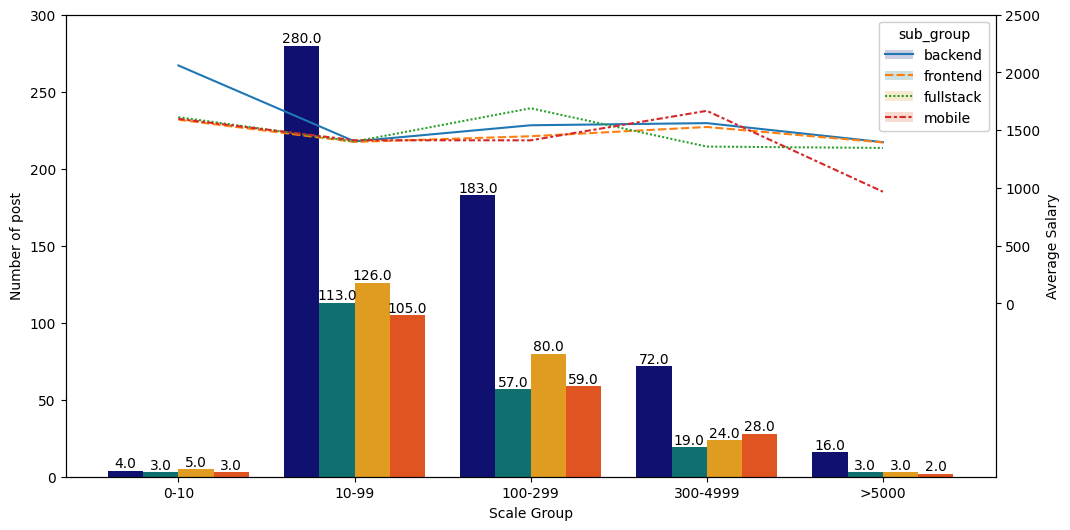

In [228]:
## Visualize the number of posts of each scale group for each sub group for It jobs
fig, ax3 = plt.subplots(figsize=(12,6))

sns.barplot(x='employer_scale_new_group',y='count',
            palette=dev_color,
            hue ='sub_group',
            order = ['0-10', '10-99', '100-299', '300-4999', '>5000'],
            data = scale_sal_final_dev,ax=ax3)
plt.ylim(0,300)
for i in ax3.containers:
    ax3.bar_label(i, fmt='%.1f')
plt.xlabel('Scale Group')
plt.ylabel('Number of post')

ax4 = ax3.twinx()
sns.lineplot(x='employer_scale_new_group',y='salary_average',hue ='sub_group',style='sub_group',sort=False,data = scale_sal_final_dev,ax=ax4)
plt.ylim(-1500)
ticks = [tick for tick in plt.gca().get_yticks() if tick >=0]
plt.gca().set_yticks(ticks)
plt.ylabel('Average Salary')

Text(0, 0.5, 'Number of post')

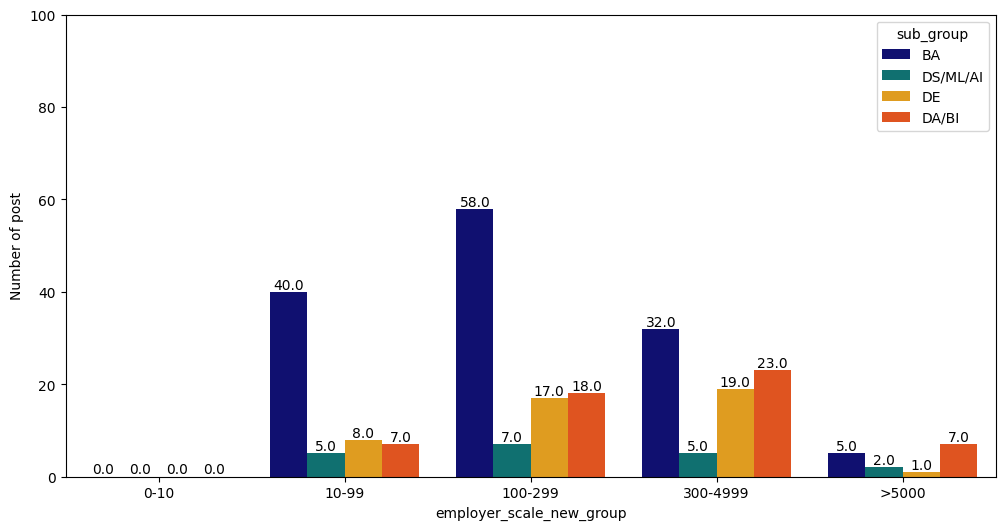

In [216]:
## Visualize the number of posts of each scale group for each sub group for Data jobss
fig, ax3 = plt.subplots(figsize=(12,6))

sns.barplot(x='employer_scale_new_group',y='count',hue ='sub_group',
            palette=data_color,
            hue_order = ['BA','DS/ML/AI','DE','DA/BI'],
            order = ['0-10', '10-99', '100-299', '300-4999', '>5000'],data = scale_sal_final_data,ax=ax3)
plt.ylim(0,100)
for i in ax3.containers:
    ax3.bar_label(i, fmt='%.1f')
plt.ylabel('Number of post')

# ax4 = ax3.twinx()
# sns.lineplot(x='employer_scale_new_group',y='salary_average',hue ='sub_group',style='sub_group',sort=False,data = scale_sal_final_data,ax=ax4)
# plt.ylim(-1500)
# ticks = [tick for tick in plt.gca().get_yticks() if tick >=0]
# plt.gca().set_yticks(ticks)
# plt.ylabel('Average Salary')

### Sal <> domain (Unchanged)

In [39]:
## Selected neccesary columns and split the scale into rows
job_df_sal_domain = salary_data[["id","salary_average","employer_domain",'employer_scale_new_group','sub_group']]
job_df_sal_domain.employer_domain = job_df_sal_domain.employer_domain.str.split(',')                                                               
job_df_sal_domain = job_df_sal_domain.explode('employer_domain')
job_df_sal_domain = job_df_sal_domain[~(job_df_sal_domain["employer_domain"] == "in")]
job_df_sal_domain = job_df_sal_domain.reset_index()

In [40]:
## Combine similar domain together
job_df_sal_domain["domain_new"] = np.NaN
for i in range(len(job_df_sal_domain)):
    if re.search('software|phan mem', job_df_sal_domain["employer_domain"][i]):
         job_df_sal_domain["domain_new"][i] = "software"
    
    elif re.search('accounting|auditing|finance|financial|invest', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "finance"
    
    elif re.search('entertainment|marketing|media|financial|invest', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "finance"
    
    elif re.search('textile|apparel & fashion|fashion|fashion social network|luxury goods & jewelry|shoes|design',job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "fashion & design"
    
    elif re.search('b2b|sales|wholesale', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "sales"
    
    elif re.search('electrical|electronic|electronics|refrigeration', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "electronical device"
    
    elif re.search('health|medical|pharmaceutical|pharmaceuticals', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "health"
    
    elif re.search('product|products', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "products"
    
    elif re.search('qa/qc', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "quality management"
    
    elif re.search('stock|bank', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "banking"
    
    elif re.search('customer|consumer', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "banking"

    elif re.search('education', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "education"

    elif re.search('supply|trade service|logistics|logistics and supply chain|supplies|delivery|shipping', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "logistics and supply chain"
    
    elif  re.search('hardware', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "logistics and supply chain"
    
    elif  re.search('high technology|information technology|program development', job_df_sal_domain["employer_domain"][i]):
        job_df_sal_domain["domain_new"][i] = "high technology"

    else: job_df_sal_domain["domain_new"][i] = job_df_sal_domain["employer_domain"][i]

In [41]:
## Counting the number of posts for each domain and remove the domain having the number post under 4
counting_domain = job_df_sal_domain['domain_new'].value_counts().to_frame().reset_index()
domain_accepted_list = counting_domain[counting_domain['domain_new'] > 3]['index'].tolist()

In [42]:
## Calculating the number of domain for each sub group
the_regroup_domain = job_df_sal_domain\
.groupby(["domain_new",'sub_group'])\
.agg({"salary_average":"mean",
      })\
.reset_index()\
.sort_values('salary_average',ascending = False)

the_regroup_domain_greater_than_3 = the_regroup_domain[the_regroup_domain['domain_new'].isin(domain_accepted_list)]

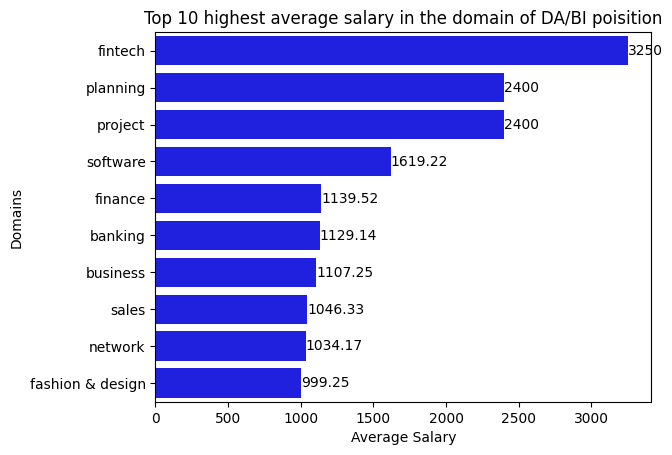

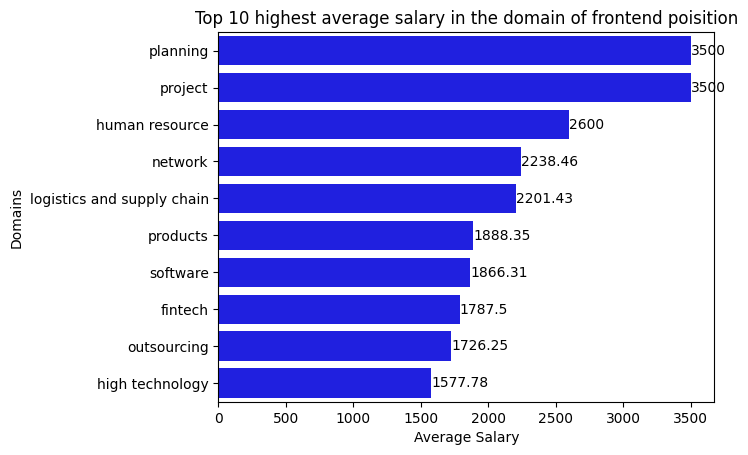

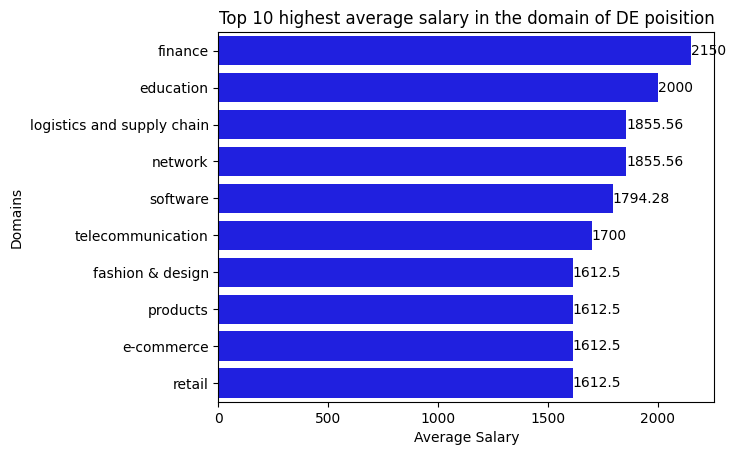

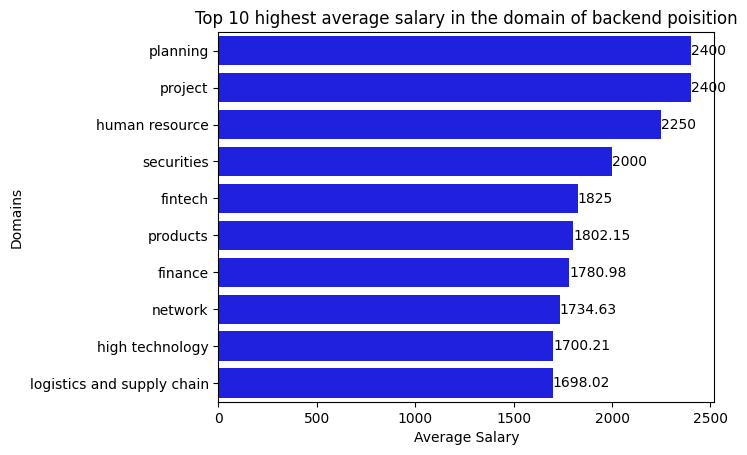

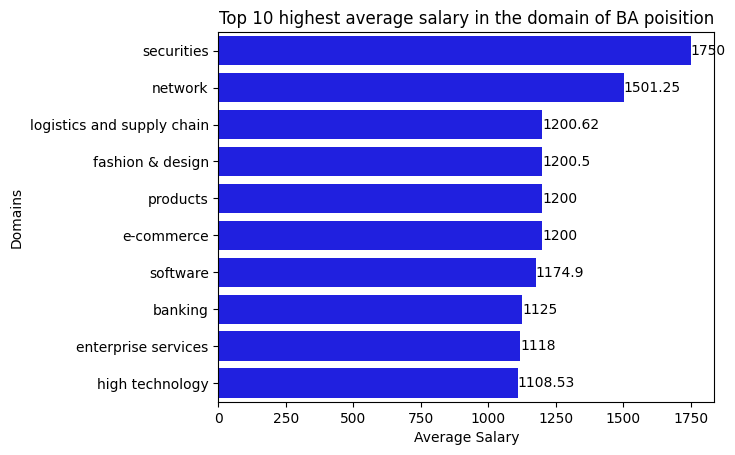

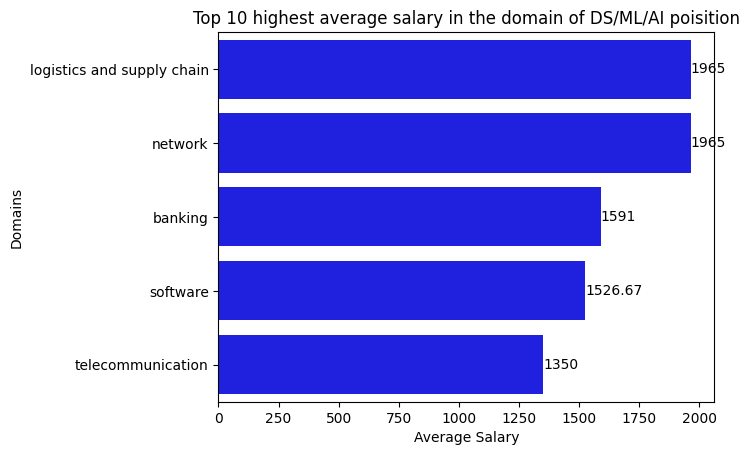

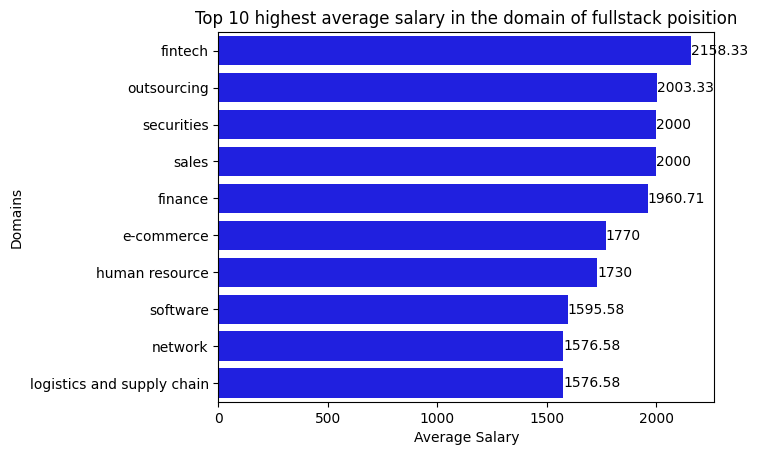

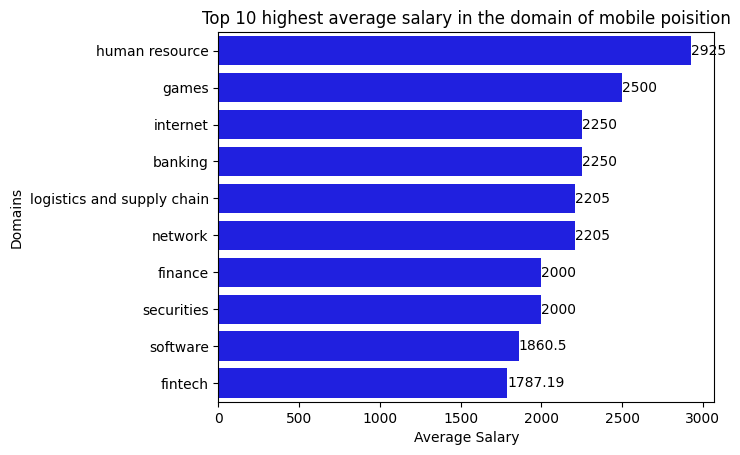

In [44]:
## Visualize top 10 domain paying highest salary for each sub-group
for i in list(set(the_regroup_domain_greater_than_3["sub_group"])):
        to_chart = the_regroup_domain_greater_than_3[(the_regroup_domain_greater_than_3.sub_group == i)].head(10)
        ax = sns.barplot(x='salary_average',y = 'domain_new',data = to_chart,ci = None, color = 'blue')
        for n in ax.containers:
                ax.bar_label(n,)
        plt.title("Top 10 highest average salary in the domain of " + i + " poisition")
        plt.xlabel('Average Salary')
        plt.ylabel('Domains')
        plt.show()

### Sal <> location (Unchanged)

In [45]:
## Selected neccessary columns and split the location into rows
job_df_sal_location = salary_data[["id","salary_average","location",'sub_group']]
job_df_sal_location.location = job_df_sal_location.location.str.split(',')                                                               
job_df_sal_location = job_df_sal_location.explode('location')
job_df_sal_location = job_df_sal_location.reset_index()

In [46]:
## Removed outliers which is the posts has salary higher than 20000
job_df_sal_location = job_df_sal_location[~(job_df_sal_location["salary_average"] > 20000)]
## Groupping the other location except HN, HCM and DN into one group
job_df_sal_location['location_new'] = np.where(~(job_df_sal_location["location"].isin(["ho chi minh","ha noi","da nang"])),
                                               "khác",job_df_sal_location["location"])

In [47]:
## Calculate the number of posts of each location for each sub groupgroup
sal_locaton_std = job_df_sal_location\
    .groupby(['location_new','sub_group'])['salary_average']\
    .std().to_frame().reset_index().sort_values("salary_average")\
    .rename({'salary_average':'std'},axis = 1)

In [48]:
## Calculating the average salary of each location for each sub group
final_sal_location = job_df_sal_location\
    .groupby(['location_new','sub_group'])\
    .agg({'salary_average':'mean'})\
    .reset_index()\
    .merge(sal_locaton_std,on=['location_new','sub_group'],how = 'inner')

## Calcuating the min and max salary of each location for eahc sub group
for i in range(len(final_sal_location)): 
    if final_sal_location['std'][i] is not np.NaN: 
        final_sal_location['min'] = final_sal_location['salary_average'] - final_sal_location['std']
        final_sal_location['max'] = final_sal_location['salary_average'] + final_sal_location['std']

In [49]:
## split the dataset into dev and data datasetdataset
final_sal_location_dev = final_sal_location[final_sal_location['sub_group'].isin(['mobile','fullstack','frontend','backend'])]
final_sal_location_data = final_sal_location[~(final_sal_location['sub_group'].isin(['mobile','fullstack','frontend','backend']))]

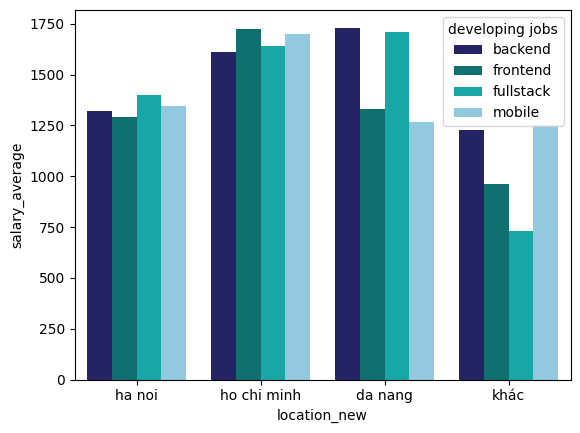

In [175]:
## Visualize the average salary of each location for each dev sub group
ax= sns.barplot(x='location_new',y='salary_average',
                palette=['midnightblue','teal','c','skyblue'],
                order = ['ha noi','ho chi minh','da nang','khác'],hue ='sub_group',data = final_sal_location_dev)
ax.legend(title="developing jobs")

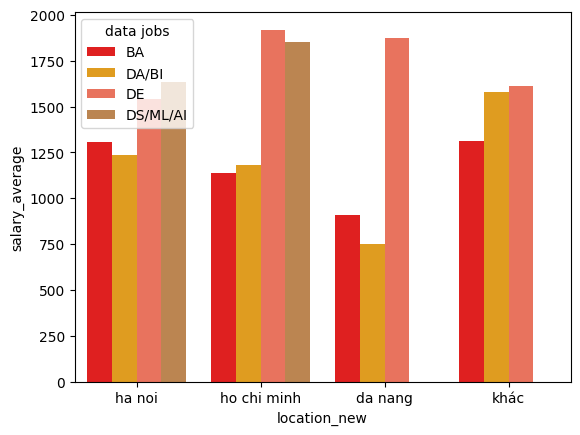

In [174]:
## Visualize the average salary of each location for each datadata sub group
ax = sns.barplot(x='location_new',y='salary_average',
                 palette=['red','orange','tomato','peru'],
                 hue ='sub_group',order = ['ha noi','ho chi minh','da nang','khác'],data = final_sal_location_data)
ax.legend(title="data jobs")

In [52]:
## Step 3: Divide city into big and small city group
# big_city = the_regroup_location[the_regroup_location["location"].isin(["ho chi minh","ha noi","da nang"])]
# small_city = the_regroup_location[~(the_regroup_location["location"].isin(["ho chi minh","ha noi","da nang"]))]

### Sal <> year_experience (unchanged)

In [53]:
## Selected neccessary columns and split the location into rows
job_df_sal_exp = salary_data[["id","salary_average","year_experience","sub_group",'min_salary','max_salary']]
job_df_sal_exp.year_experience = job_df_sal_exp.year_experience.str.split(',')                                                               
job_df_sal_exp = job_df_sal_exp.explode('year_experience')
job_df_sal_exp = job_df_sal_exp.reset_index()

In [54]:
## Group year experiences under 1 years into a group and year experience more than 5 years into a group
job_df_sal_exp['year_experience'] = np.where(job_df_sal_exp['year_experience'].isin(['03 month','06 month']),"under 1 year",
                                        np.where(job_df_sal_exp['year_experience'].isin(['5 year','6 year','7 year']),'from 5 year',
                                               job_df_sal_exp['year_experience']))

In [55]:
## Calculate the average salary of each year experience group for each sub group
the_regroup_job_sal_exp = job_df_sal_exp\
.groupby(["year_experience","sub_group"])\
.agg({
      "salary_average":"mean",
      })\
.reset_index()

## Removed irrelevant year experience like unknown and all levels
the_regroup_job_sal_exp = the_regroup_job_sal_exp[~(the_regroup_job_sal_exp['year_experience'].isin(['unknown','all levels']))]

In [56]:
## Adding missing group 
for i in set(the_regroup_job_sal_exp['sub_group']):
    test = the_regroup_job_sal_exp[the_regroup_job_sal_exp['sub_group'] == i]
    for n in ["under 1 year","1 year","2 year","3 year","4 year","from 5 year"]:
        if n not in list(set(test['year_experience'])):
                new_row = {'sub_group':i, 'year_experience':n, 'salary_average':0}
                the_regroup_job_sal_exp = the_regroup_job_sal_exp.append(new_row, ignore_index=True)


In [57]:
## Sort the year experience from smallest to the highesthighest
sorter = ["under 1 year","1 year","2 year","3 year","4 year","from 5 year"]
the_regroup_job_sal_exp.sort_values(by="year_experience", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)

In [58]:
## Detach the dataset for dev and datadata
the_regroup_job_sal_exp_dev = the_regroup_job_sal_exp[the_regroup_job_sal_exp['sub_group'].isin(['mobile','frontend','backend','fullstack'])].reset_index()
the_regroup_job_sal_exp_data = the_regroup_job_sal_exp[~(the_regroup_job_sal_exp['sub_group'].isin(['mobile','frontend','backend','fullstack']))].reset_index()

(0.0, 2500.0)

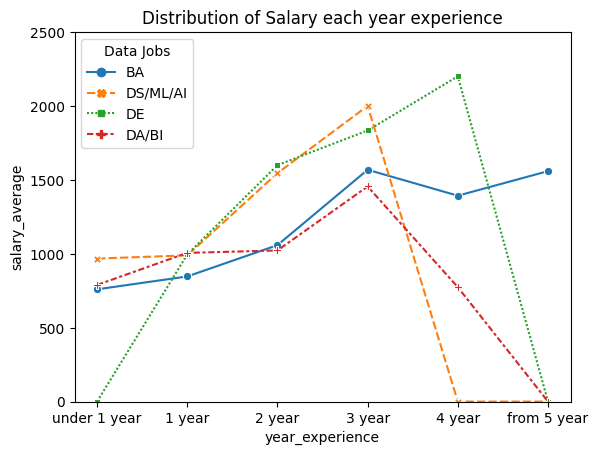

In [59]:
## Visualize the average salary over the year experience for each data sub group
ax = sns.lineplot(x = 'year_experience',
            y = 'salary_average',
            hue = 'sub_group',
            data = the_regroup_job_sal_exp_data,
            style = 'sub_group',
            markers=True
            )

ax.legend(title='Data Jobs')
plt.title('Distribution of Salary each year experience')
plt.ylim(0,2500)

(0.0, 2500.0)

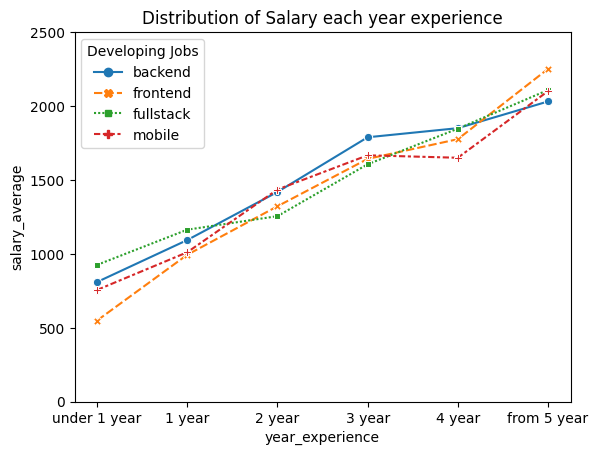

In [60]:
## Visualize the average salary over the year experience for each dev sub group
ax = sns.lineplot(x = 'year_experience',
            y = 'salary_average',
            hue = 'sub_group',
            style = 'sub_group',
            markers=True,
            data = the_regroup_job_sal_exp_dev)
ax.legend(title='Developing Jobs')
plt.title('Distribution of Salary each year experience')
plt.ylim(0,2500)

In [61]:
# # Step 10-b: visualize the number of value inside each group
# # Calculate number of data in each group
# for i in list(set(the_regroup_job_sal_exp["sub_group"])):
#         to_chart = the_regroup_job_sal_exp[the_regroup_job_sal_exp["sub_group"] == i]
#         ## reorder the position of each group
#         to_chart.sort_values(by=['salary_average'], inplace=True)
#         # plotting the chart
#         plt.figure(figsize=(10, 12))
#         ax = sns.barplot(x = 'year_experience',
#             y = 'salary_average',
#             order = ["under 1 year","1 year","2 year","3 year","4 year","5 year","6 year","7 year","all levels"],
#             data = to_chart)
#         for n in ax.containers:
#                 ax.bar_label(n,)
#         ax.set_xlabel("Year Experience")
#         ax.set_ylabel("Average Salary")
#         plt.title('Average salary per year experience of ' + i + ' position')
#         plt.show()

### Sal <> Exp+Level (Unchanged)

In [62]:
## Selected neccessary columns and split the location into rows
job_df_sal_exp_level = job_df[["id","salary_average",'level',"year_experience","sub_group"]]
job_df_sal_exp_level.year_experience = job_df_sal_exp_level.year_experience.str.split(',')                                                               
job_df_sal_exp_level = job_df_sal_exp_level.explode('year_experience')
job_df_sal_exp_level.level = job_df_sal_exp_level.level.str.split(',')                                                               
job_df_sal_exp_level = job_df_sal_exp_level.explode('level')
job_df_sal_exp_level = job_df_sal_exp_level.reset_index()

In [63]:
## Group year experiences under 1 years into a group and year experience more than 5 years into a group
job_df_sal_exp_level['year_experience'] = np.where(job_df_sal_exp_level['year_experience'].isin(['03 month','06 month']),"under 1 year",
                                               job_df_sal_exp_level['year_experience'])
job_df_sal_exp_level = job_df_sal_exp_level[~(job_df_sal_exp_level.level.isin(['unknown','general staff']))]
job_df_sal_exp_level = job_df_sal_exp_level[~(job_df_sal_exp_level.year_experience.isin(['unknown']))]

In [64]:
## Combine Level and year experience text
job_df_sal_exp_level['exp_level'] = job_df_sal_exp_level['level'] + " " + job_df_sal_exp_level['year_experience']

In [65]:
## Counting the number of post for each pair of year experience and level for each sub group
the_regroup_job_sal_exp_level = job_df_sal_exp_level\
.groupby(["exp_level","sub_group"])\
.agg({
      "salary_average":"median",
      })\
.reset_index()

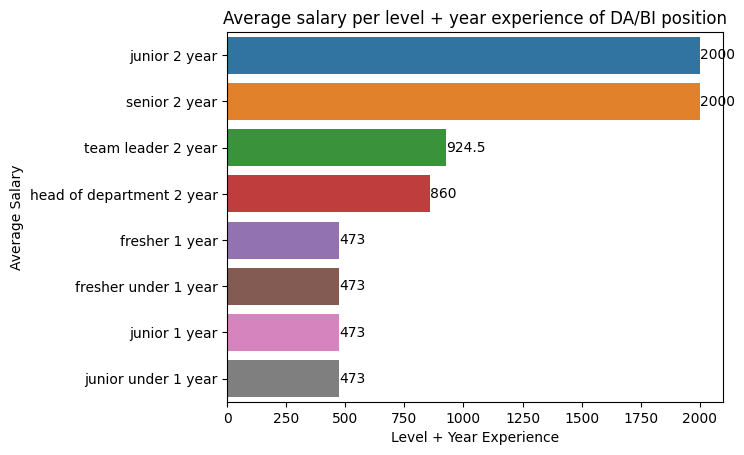

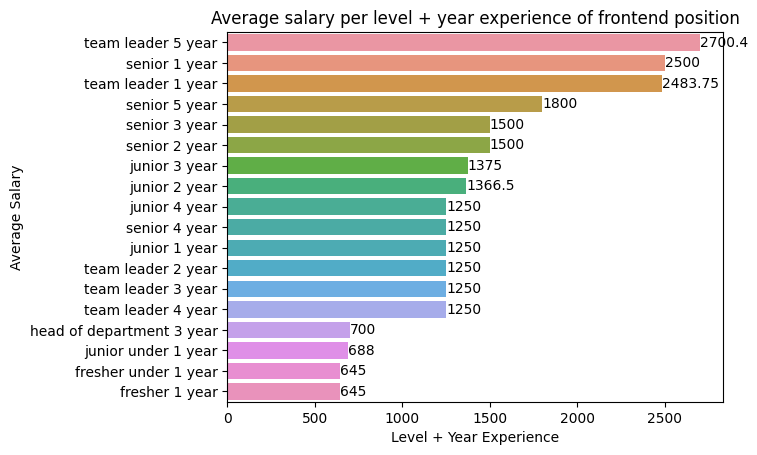

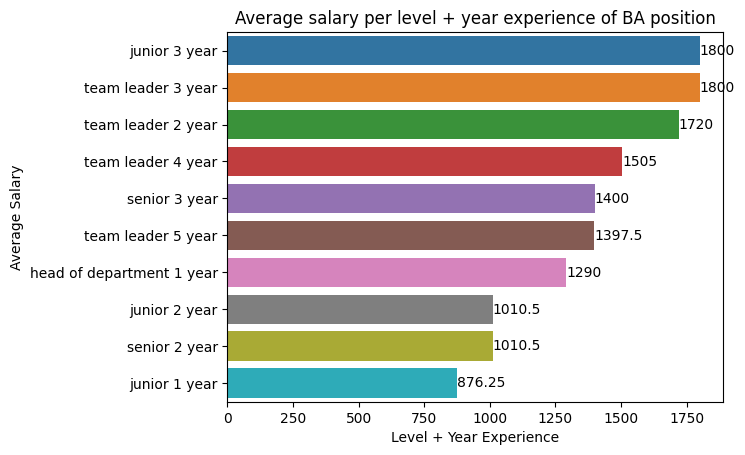

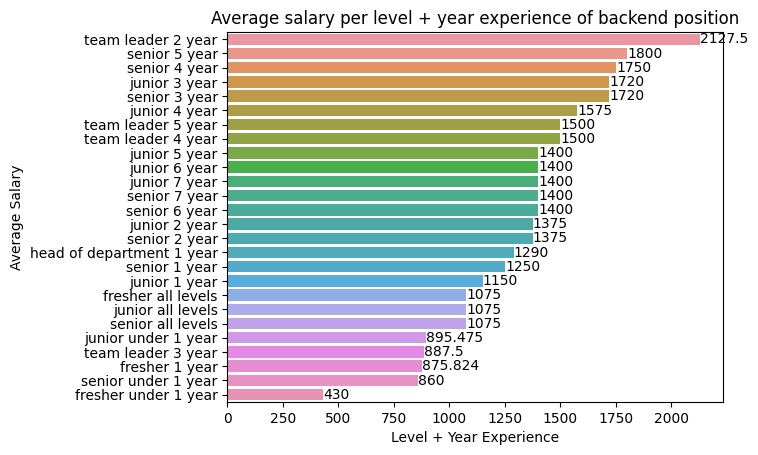

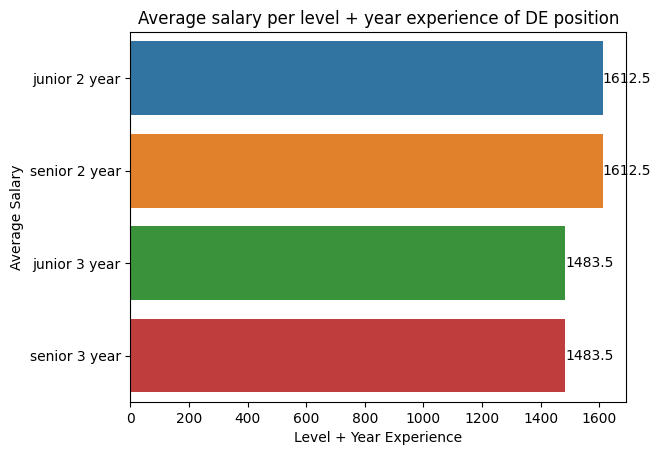

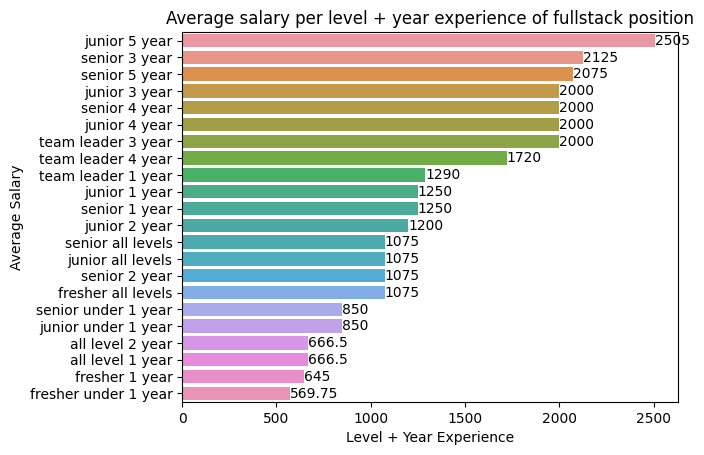

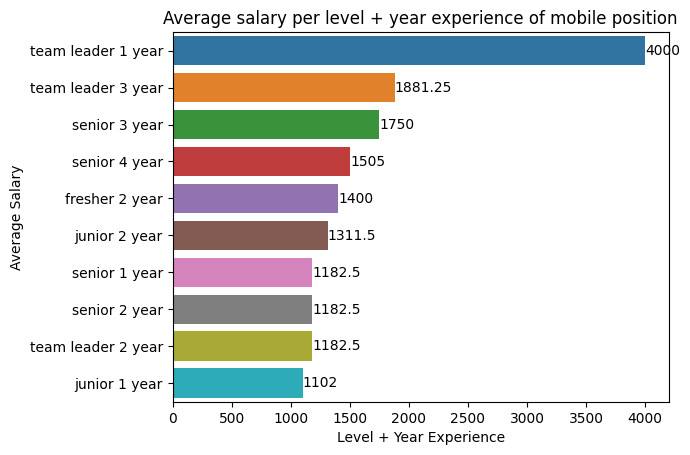

In [66]:
# visualize the number of posts for each pair of level and year experience in each group
# Calculate number of data in each group
for i in list(set(the_regroup_job_sal_exp_level["sub_group"])):
        to_chart = the_regroup_job_sal_exp_level[the_regroup_job_sal_exp_level["sub_group"] == i]
        ## reorder the position of each group
        to_chart.sort_values(by=['salary_average'],ascending = False, inplace=True)
        # plotting the chart
        ax = sns.barplot(x = 'salary_average',
            y = 'exp_level',
            data = to_chart)
        for n in ax.containers:
                ax.bar_label(n,)
        ax.set_xlabel("Level + Year Experience")
        ax.set_ylabel("Average Salary")
        plt.title('Average salary per level + year experience of ' + i + ' position')
        plt.show()

### Sal <> level (Unchanged)

In [67]:
## Selected neccessary columns and split the location into rows
job_df_sal_level = salary_data[["id","salary_average","level",'sub_group','year_experience']]
job_df_sal_level.level = job_df_sal_level.level.str.split(',')                                                               
job_df_sal_level = job_df_sal_level.explode('level')

In [68]:
## Review dataset
job_df_sal_level

id  salary_average          level sub_group year_experience
0        ITV3533          1750.0        unknown   backend         unknown
1        ITV2405          1150.0        unknown   backend         unknown
2        ITV4923          1500.0        unknown    mobile         unknown
3        ITV3405           750.0        unknown  frontend         unknown
4        ITV0343          1750.0        unknown   backend         unknown
...          ...             ...            ...       ...             ...
1461  VNW1626388          1500.0  general staff        BA         unknown
1462  VNW1617129          2000.0  general staff        BA         unknown
1463  VNW1608792           950.0  general staff        BA         unknown
1464  VNW1618578           550.0  general staff     DA/BI         unknown
1465  VNW1626610           900.0  general staff     DA/BI         unknown

[1560 rows x 5 columns]

In [69]:
## Relabled Head of department and team leader into 1 label (leader)
job_df_sal_level['level_test'] = np.where(job_df_sal_level['level'].isin(['head of department','team leader']),
                                                                         'leader',job_df_sal_level['level'])

In [70]:
## Calculate the average salary of each level in each sub group
the_regroup_sal_level = job_df_sal_level\
.groupby(["level_test",'sub_group'])\
.agg({
      "salary_average":"median",
      })\
.reset_index()
the_regroup_sal_level = the_regroup_sal_level[~(the_regroup_sal_level['level_test'].isin(['unknown','all level']))]

In [71]:
## Pivot the table 
table = pd.pivot_table(the_regroup_sal_level, values ='salary_average', index =['level_test'],
                         columns =['sub_group'], aggfunc = 'first').fillna(0).reset_index()
table

sub_group     level_test       BA    DA/BI      DE  DS/ML/AI  backend  \
0                fresher     0.00   473.00     0.0       0.0    666.5   
1          general staff  1175.00  1075.00  1625.0    1376.0   1290.0   
2                 junior  1005.25  1236.50  1548.0       0.0   1250.0   
3                 leader  1612.50  1962.25  2000.0       0.0   1500.0   
4                 senior  1010.50  2000.00  1548.0       0.0   1500.0   

sub_group  frontend  fullstack   mobile  
0             645.0      860.0  1300.00  
1            1075.0     1247.0  1270.00  
2            1366.5     1250.0  1247.00  
3            1975.2     1860.0  1881.25  
4            1502.5     1500.0  1398.75

In [72]:
## Sorting the level from smallest to highest
sorter = ["fresher","junior",'senior','leader','general staff']
the_regroup_sal_level.sort_values(by="level_test", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)

In [73]:
## Detach the dataset in to dev and data dataset
the_regroup_sal_level_dev = the_regroup_sal_level[the_regroup_sal_level['sub_group'].isin(['mobile','fullstack','frontend','backend'])]
the_regroup_sal_level_data = the_regroup_sal_level[~(the_regroup_sal_level['sub_group'].isin(['mobile','fullstack','frontend','backend']))]

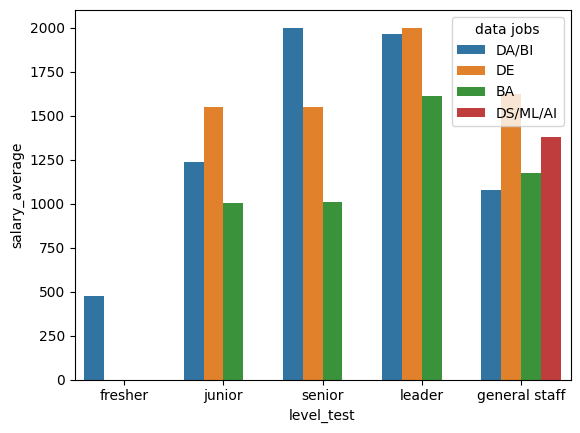

In [74]:
## Visualize the avarage salary of each level in data sub-group
ax= sns.barplot(x='level_test',y='salary_average',hue ='sub_group',data = the_regroup_sal_level_data)
ax.legend(title="data jobs")

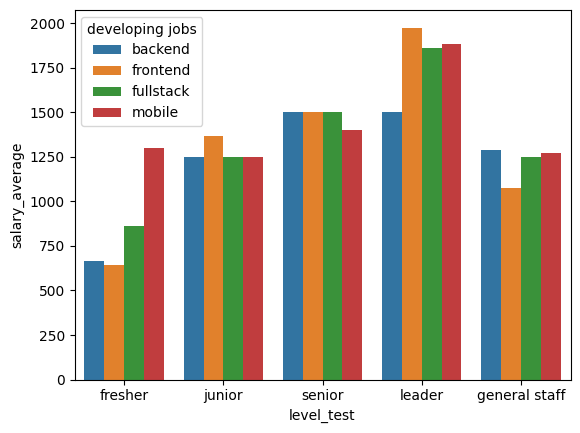

In [75]:
## Visualize the avarage salary of each level in devdev sub-group
ax= sns.barplot(x='level_test',y='salary_average',hue ='sub_group',data = the_regroup_sal_level_dev)
ax.legend(title="developing jobs")

In [76]:
# for i in list(set(the_regroup_sal_level["sub_group"])):
#         to_chart = the_regroup_sal_level[(the_regroup_sal_level.sub_group == i)]
#         ax = sns.barplot(x='salary_average',y = 'level_test',
#         order = ['fresher','junior','senior','leader'],data = to_chart)
#         for n in ax.containers:
#                 ax.bar_label(n,)
#         plt.title("Average salary per level in " + i + " poisition")
#         plt.xlabel('salary_average')
#         plt.ylabel('level')
#         plt.show()

In [77]:
# for i in list(set(the_regroup_sal_level["sub_group"])):
#         to_chart = the_regroup_sal_level[(the_regroup_sal_level.sub_group == i)]
#         ax = sns.barplot(x='salary_average',y = 'level',
#         order = ['fresher','junior','senior','team leader','head of department'],data = to_chart)
#         for n in ax.containers:
#                 ax.bar_label(n,)
#         plt.title("Average salary per level in " + i + " poisition")
#         plt.xlabel('salary_average')
#         plt.ylabel('level')
#         plt.show()

## 3/ Skills, skill and skill tag

#### skill in general

In [78]:
## Selected neccessary columns and split the location into rows
skill_df = job_df_new[["id","skill","sub_group",'min_salary','max_salary','salary_average','year_experience']]
skill_df.skill = skill_df.skill.str.split(',')                                                               
skill_df = skill_df.explode('skill')
skill_df = skill_df[~(skill_df["skill"].isnull())]
skill_df = skill_df.reset_index()
skill_df["skill"] = skill_df["skill"].apply(lambda x: x.strip())

In [79]:
## Removed irrelevant skills 
skill_new_df = skill_df[~(skill_df["skill"].isin(["nan","fresher accepted","product owner","po (product owner)","full-stack","back-end","backend","remote","asp net software engineer","front-end","fresher accepted",
                                              "back-end web development","software developer","game developer","backend programming","software engineer","front end","designer",
                                              "frontend developer",'[hanoi] - machine learning engineer','unknown']))].reset_index()

In [80]:
## Grouping similar skills into a group
skill_new_df["skill_new"] = np.NaN
for i in range(len(skill_new_df)):
    if re.search('analysis|analyst|analytical|analyze', skill_new_df["skill"][i]):
         skill_new_df["skill_new"][i] = "analyst"
    
    elif re.search('manager|management|managing', skill_new_df["skill"][i]):
        skill_new_df["skill_new"][i] = "management"
    
    elif re.search('communication|consultant|presentation', skill_new_df["skill"][i]):
        skill_new_df["skill_new"][i] = "communication"
    
    elif re.search('problem', skill_new_df["skill"][i]):
        skill_new_df["skill_new"][i] = "problem solving"
    
    elif re.search('logical', skill_new_df["skill"][i]):
        skill_new_df["skill_new"][i] = "logical thinking"
    
    elif re.search('teamwork|team work|collaboration|working group', skill_new_df["skill"][i]):
        skill_new_df["skill_new"][i] = "teamwork"
    
    elif re.search('planning|plan', skill_new_df["skill"][i]):
        skill_new_df["skill_new"][i] = "planning skill"
    
    elif re.search('writing|reporting|documentation', skill_new_df["skill"][i]):
        skill_new_df["skill_new"][i] = "writing skill"
    
    elif re.search('leader|leadership', skill_new_df["skill"][i]):
        skill_new_df["skill_new"][i] = "leadership"
    
    elif re.search('nosql', skill_new_df["skill"][i]):
         skill_new_df["skill_new"][i] = "nosql"

    elif re.search('mysql|my sql| sql ', skill_new_df["skill"][i]):
         skill_new_df["skill_new"][i] = "mysql"

    elif re.search('git|github', skill_new_df["skill"][i]):
         skill_new_df["skill_new"][i] = "git"
    
    elif re.search('english|ielts|toeic|toiec', skill_new_df["skill"][i]):
         skill_new_df["skill_new"][i] = "english"
    
    elif re.search('specialist|senior|junior', skill_new_df["skill"][i]):
        skill_new_df["skill_new"][i] = str(skill_new_df["skill_new"][i]).replace('specialist','')
        skill_new_df["skill_new"][i] = str(skill_new_df["skill_new"][i]).replace('senior','')
        skill_new_df["skill_new"][i] = str(skill_new_df["skill_new"][i]).replace('junior','')

    else: skill_new_df["skill_new"][i] = skill_new_df["skill"][i]

In [81]:
## Label coreskills
coreskill_list = ['analyst','management','communication','problem solving','logical thinking',
'teamwork','planning skill','writing skill','leadership','arrange and plan','can do attitude','careful',
'chinese','chinese language','english','withstand pressure','work independently','japanese','korean','proactive and eager to learn','requirements gathering']

In [82]:
## Making consitent content in column translation by revise if they contain any relevant words
skill_new_df["skill_group"] = np.NaN

for i in range(len(skill_new_df)):

  if (skill_new_df["skill_new"][i] in coreskill_list):
    skill_new_df["skill_group"][i] = "core_skill"

  else: skill_new_df["skill_group"][i] = "functional_skill"

In [83]:
## Counting the number of skills required for each sub group
count_skill_per_sub_group = skill_new_df[["sub_group","skill_new",'skill_group']].value_counts().reset_index()
count_skill_per_sub_group = count_skill_per_sub_group.rename({0:"count"},axis=1)


In [84]:
## Add label of color for core and soft skills ( the visualization will based on this to chooose colors for each skillsskills)
custom_palette = {}
for q in set(count_skill_per_sub_group.skill_new):
    if q in coreskill_list:
        custom_palette[q] = 'r'
    else:
        custom_palette[q] = 'b'

In [85]:
## Convert year experience from text to number
skill_new_df['year_experience_new'] = np.where(skill_new_df['year_experience'] == 'under 1 year',0.5,
                                          np.where(skill_new_df['year_experience'] == '1 year',1,
                                                   np.where(skill_new_df['year_experience'] == '2 year',2,
                                                            np.where(skill_new_df['year_experience'] == '3 year',3,
                                                                     np.where(skill_new_df['year_experience'] == '4 year',4,
                                                                              np.where(skill_new_df['year_experience'] == '5 year',5,
                                                                                       np.where(skill_new_df['year_experience'] == '6 year',6,
                                                                                                np.where(skill_new_df['year_experience'] == '7 year',7,'others'
                                                   ))))))))
## Removed others in skills
skill_new_df = skill_new_df[~(skill_new_df['year_experience_new'].isin(['others']))]

## Convert text to number
skill_new_df['year_experience_new'] = skill_new_df['year_experience_new'].apply(lambda x: float(x))
skill_new_df['min_salary'] = skill_new_df['min_salary'].apply(lambda x: float(x))
skill_new_df['max_salary'] = skill_new_df['max_salary'].apply(lambda x: float(x))

In [86]:
#### Counting the number of skills required for each sub group
skill_counting = skill_new_df['skill_new'].value_counts().to_frame().reset_index().rename({"index":"skill",'skill_new':"count"},axis = 1)
### Remove skills under 55
skill_counting_list = skill_counting[skill_counting['count'] >= 5]['skill'].tolist()

In [87]:
## Calculating the min and max salary for each skills 
to_chart_skill_sal = skill_new_df\
    .groupby(['skill_new'])\
    .agg({'min_salary':"mean",
          'max_salary':'mean'})\
    .reset_index()

## Rounding
to_chart_skill_sal = to_chart_skill_sal[to_chart_skill_sal['skill_new'].isin(skill_counting_list)]
to_chart_skill_sal['min_salary'] = to_chart_skill_sal['min_salary'].apply(lambda x: round(x,0))
to_chart_skill_sal['max_salary'] = to_chart_skill_sal['max_salary'].apply(lambda x: round(x,0))

In [88]:
## Combine min and max into a range for each skills
to_chart_skill_sal['salary_range'] = to_chart_skill_sal['min_salary'].astype(str) + '-' +to_chart_skill_sal['max_salary'].astype(str)
skill_sal = count_skill_per_sub_group.merge(to_chart_skill_sal,on = ['skill_new'],how='inner').reset_index()

In [89]:
## Convert skill dataset to a listlist
skill_list = to_chart_skill_sal['skill_new'].tolist()
# exp_list = to_chart_skill_sal['year_experience_new'].tolist()
# sal_list = to_chart_skill_sal['salary_average'].tolist()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DA/BI


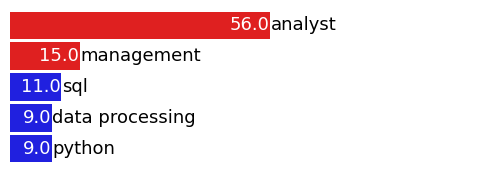

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


frontend


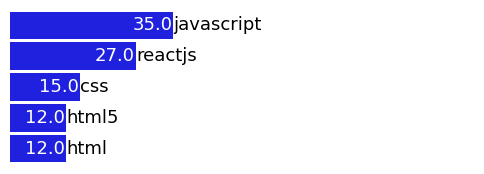

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DE


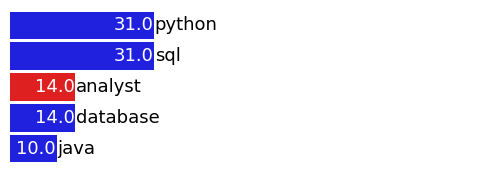

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


backend


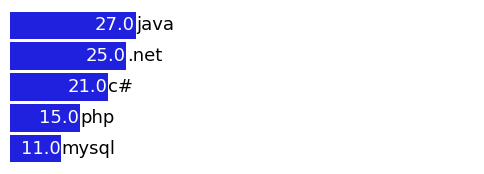

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


BA


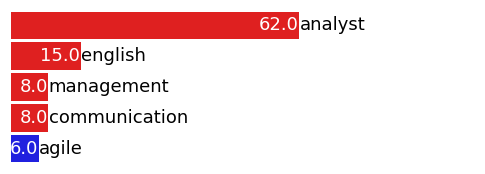

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DS/ML/AI


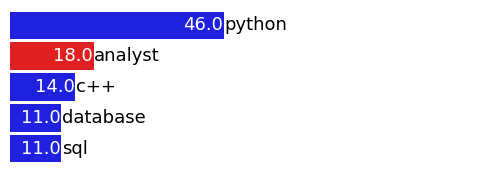

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


fullstack


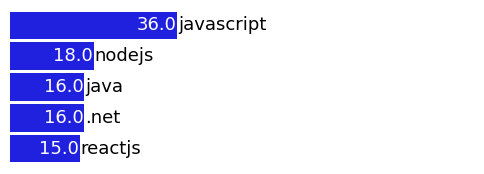

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


mobile


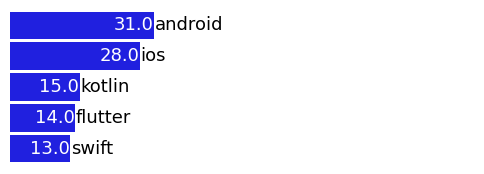

In [90]:
## Visualize the average salary for each skills in each sub groupsgroups
for i in list(set(skill_sal['sub_group'])):
    print(i)
    to_chart = skill_sal[(skill_sal.sub_group == i)]\
        .sort_values('count',ascending = False)\
        .dropna()\
        .head(5)\
        .reset_index()
    to_chart['percent'] = to_chart['count'].apply(lambda x: round(x/sum(to_chart['count']),2)*100)
    plt.figure(figsize=(6, 2))
    ax = sns.barplot(x='percent',y = 'skill_new',width=0.9,data = to_chart,palette=custom_palette)
    if max(to_chart['percent']) <= 20:
        step = 2
    elif max(to_chart['percent']) <= 50:
        step = 5
    else: step = 10
    plt.xticks(np.arange(0, max(to_chart['percent'])*1.2,step))
    for index, value in enumerate(round(to_chart['percent'],2)):
        plt.text(value-0.1, index, str(value),ha = 'right',va = 'center',color='white',fontsize = 13)
    
    old_ticks = ax.get_yticks()
    for n in range(len(old_ticks)):
        plt.text(list(to_chart['percent'])[n]+0.1, n , list(to_chart['skill_new'])[n], ha = 'left', va = 'center', color = 'black', fontsize = 13)

    # plt.title("Top 10 skills required by " + i + " poisition")
    red_patch = mpatches.Patch(color='red', label='Soft_skills')
    blue_patch = mpatches.Patch(color='blue', label='Domain_skills')
    plt.legend(handles=[red_patch, blue_patch],loc = 'lower right')
    # plt.xlabel('percent (%)')
    # plt.ylabel('skills')
    ax.legend().set_visible(False)
    ax.margins(x=0.005)
    plt.axis('off')
    plt.xlim(0,100)
    plt.show()

## 4/ Location


##### General

In [91]:
## Extract neccessary columns from the original dataset
location_df = salary_data[["id","location",'sub_group','min_salary','max_salary']]
## Combine min and max dataset into a range
location_df['range'] = location_df['min_salary'] + ' - ' + location_df['max_salary']
location_df['min_salary'] = location_df['min_salary'].apply(lambda x: float(x))
location_df['max_salary'] = location_df['max_salary'].apply(lambda x: float(x))


In [92]:
## Split the location into rows (because the a post can contain many locations)
location_df.location = location_df.location.str.split(',')                                                               
location_df = location_df.explode('location')

In [93]:
## Grouping cities except HN, HCM and DN into a group
location_df["New_location"] = np.where(~(location_df["location"].isin(["ho chi minh","ha noi","da nang"])),"khác",location_df["location"])

In [ ]:
## Calculate the number of location for each sub group
to_chart_location = location_df[["New_location",'sub_group']].value_counts().to_frame().reset_index()
to_chart_location = to_chart_location.rename({0:"count"},axis = 1)

In [94]:
## Calculate the average of salary for each location
to_chart_location_sal = location_df\
    .groupby(["New_location",'sub_group'])\
    .agg({'min_salary':'mean',
          'max_salary':'mean'})\
    .reset_index()
to_chart_location_combine = to_chart_location.merge(to_chart_location_sal,on=["New_location",'sub_group'],how='inner')

## Rounding
to_chart_location_combine['min_salary'] = to_chart_location_combine['min_salary'].apply(lambda x: round(x,0))
to_chart_location_combine['max_salary'] = to_chart_location_combine['max_salary'].apply(lambda x: round(x,0))
to_chart_location_combine['salary_range'] = to_chart_location_combine['min_salary'].astype(str) + ' - ' + to_chart_location_combine['max_salary'].astype(str)

In [95]:
## Detach the dataset into dev and data datasetdataset
final_location_dev = to_chart_location_combine[to_chart_location_combine['sub_group'].isin(['mobile','fullstack','frontend','backend'])]
final_location_data = to_chart_location_combine[~(to_chart_location_combine['sub_group'].isin(['mobile','fullstack','frontend','backend']))]

In [179]:
def location_chart(df,palette_range):
    '''
    This function is to draw a chart with identified color range
    '''
    final_to_chart = pd.DataFrame(columns = ['New_location','sub_group','count','min_salary','max_salary','salary_range'])
    sorter = ['ha noi','ho chi minh','da nang','khác']
    for i in list(df['sub_group'].unique()):
        dataset = df[df['sub_group'] == i]
        dataset.sort_values(by="New_location", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)
        final_to_chart = pd.concat([final_to_chart,dataset],axis=0)

    count_list = final_to_chart['count'].tolist()
    sal_range_list = final_to_chart['salary_range'].tolist()

    ax = sns.barplot(x='count',y='New_location',
                     palette=palette_range,
                     order = ['ha noi','ho chi minh','da nang','khác'],hue ='sub_group',data = final_to_chart)
    y_position_list = []
    for g in ax.patches:
        y_position = g.get_xy()[1]
        y_position_list.append(y_position)

    for i in range(len(final_to_chart)):
        plt.text(x=count_list[i],y=y_position_list[i]+0.15,s=sal_range_list[i])
    
    plt.xlabel('Number of post')
    plt.ylabel('location')
    plt.title('Distribution of job post and salary range over location')


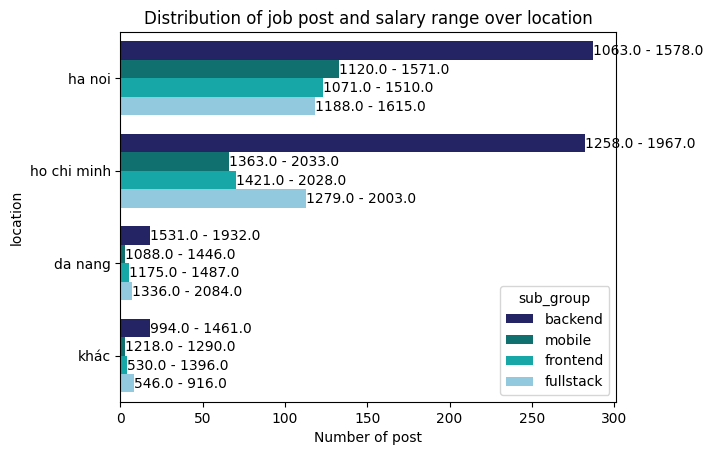

In [187]:
## Visualize the average salary for each location in dev sub group
location_chart(final_location_dev,dev_color)

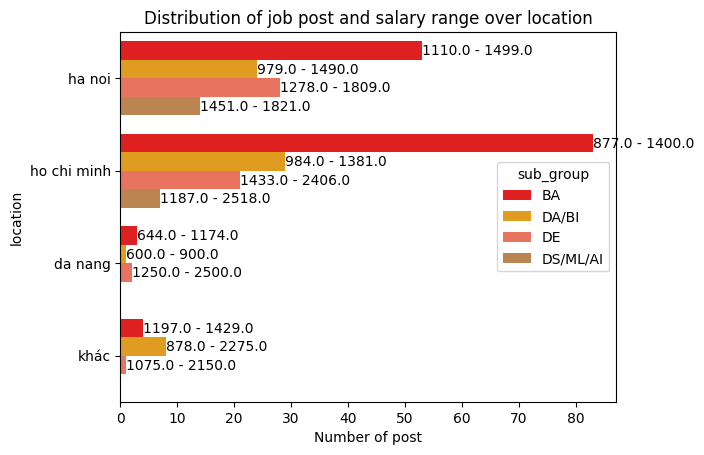

In [188]:
## Visualize the average salary for each location in dataata sub group
location_chart(final_location_data,data_color)

In [99]:
# ## Step 5: The disparity between HCM and ha noi and da nang
# print(big_city["location"].value_counts()[1]/big_city["location"].value_counts()[0])
# print(big_city["location"].value_counts()[2]/big_city["location"].value_counts()[0])

## 5/ Post_date

In [100]:
## Step 1: convert string format to datetime format
job_df["post_date"] = job_df["post_date"].apply(lambda x: parser.parse(x))

In [118]:
## Step 2-b:the number of post in each portal per day
cross_tab_prop = pd.crosstab(index=job_df['post_date'],columns=job_df['group']).reset_index().set_index('post_date')
idx = pd.date_range('26-11-2022', '04-01-2023')
cross_tab_prop.index = pd.DatetimeIndex(cross_tab_prop.index)
cross_tab_prop = cross_tab_prop.reindex(idx, fill_value=0).reset_index()
cross_tab_prop["total_post"] = cross_tab_prop["developer"] + cross_tab_prop["data"]
cross_tab_prop.rename(columns = {"index":"post_date"}, inplace = True)

(0.0, 238.35)

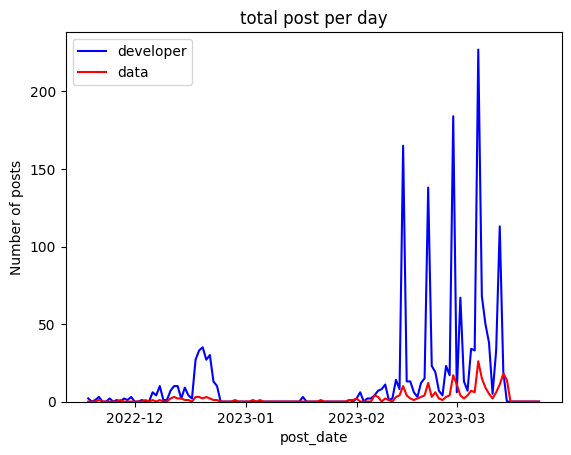

In [120]:
## Visualize the number of posts over the time for each sub groupgroup
fig, ax = plt.subplots() 
ax.plot('post_date', 'developer', data = cross_tab_prop, color ="blue")
ax.plot('post_date', 'data', data = cross_tab_prop, color ="red")   
# ax.set_xticklabels([x.strftime("%Y-%b") for x in cross_tab_prop['post_date']])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1, bymonthday = 9))
plt.tick_params(axis='x', rotation=0)
leg = ax.legend()
plt.title("total post per day")
plt.xlabel("post_date")
plt.ylabel("Number of posts")
plt.ylim(0)

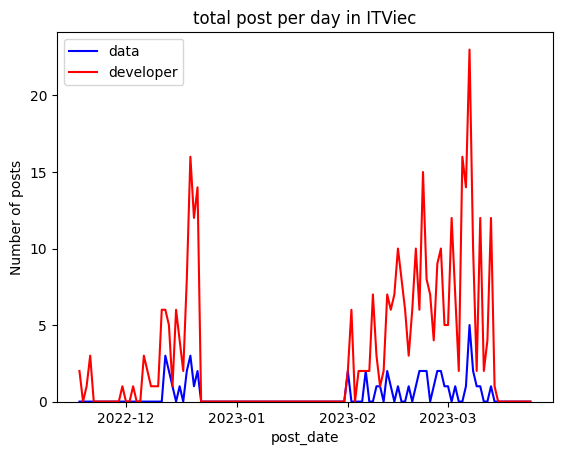

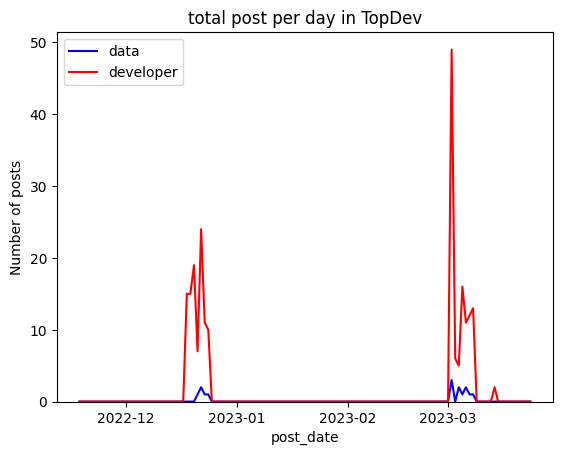

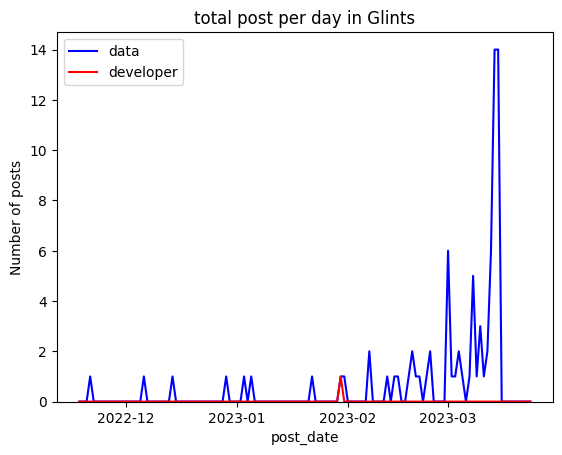

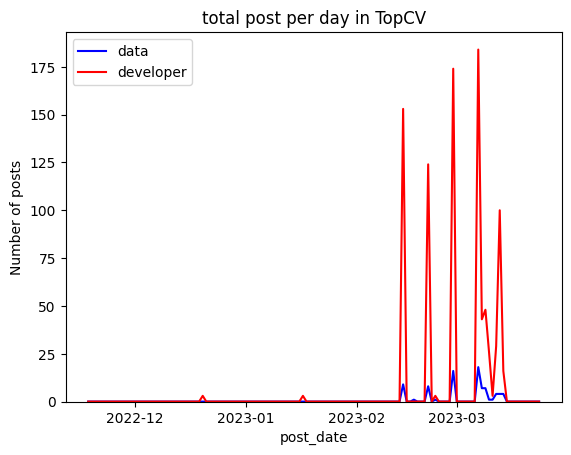

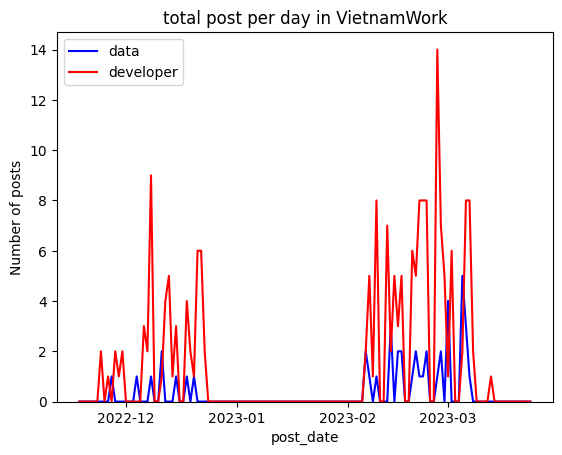

In [122]:
## Visualize the number of post in each portal per day for each job portal
job_df["portal"] = np.where(job_df["portal"] == "Vietnamwork","VietnamWork",job_df["portal"])
for i in list(set(job_df["portal"])):
    date_df = job_df[job_df["portal"] == i]
    cross_tab_prop = pd.crosstab(index=date_df['post_date'],columns=date_df['group']).reset_index().set_index('post_date')
    idx = pd.date_range('26-11-2022', '04-01-2023')
    cross_tab_prop.index = pd.DatetimeIndex(cross_tab_prop.index)
    cross_tab_prop = cross_tab_prop.reindex(idx, fill_value=0).reset_index()
    cross_tab_prop.rename(columns = {"index":"post_date"}, inplace = True)
    fig, ax = plt.subplots() 
    ax.plot('post_date', 'data', data = cross_tab_prop, color ="blue")
    ax.plot('post_date', 'developer', data = cross_tab_prop, color ="red")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1, bymonthday = 9))
    plt.tick_params(axis='x', rotation=0)
    leg = ax.legend()
    plt.title("total post per day in" + " " +i)
    plt.xlabel("post_date")
    plt.ylabel("Number of posts")
    plt.ylim(0)
    plt.show()

(0.0, 24.15)

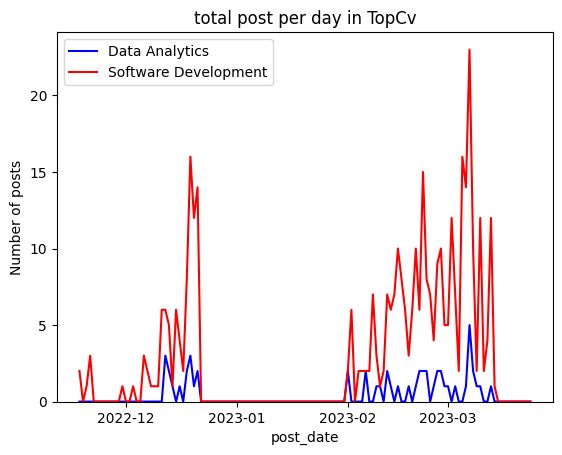

In [ ]:
fig, ax = plt.subplots() 
ax.plot('post_date', 'Data Analytics', data = cross_tab_prop, color ="blue")
ax.plot('post_date', 'Software Development', data = cross_tab_prop, color ="red")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1, bymonthday = 9))
plt.tick_params(axis='x', rotation=0)
leg = ax.legend()
plt.title("total post per day in TopCv")
plt.xlabel("post_date")
plt.ylabel("Number of posts")
plt.ylim(0)

##### Draft

In [ ]:
# pivot_date = date_df\
#               .groupby(['post_date','job_group'])\
#               .agg({"ITViec":"sum",
#                     "TopDev":"sum",
#                     "Vietnamwork":"sum"})\
#               .reset_index()\

# idx = pd.date_range('26-11-2022', '01-01-2023')

# dev_pivot_date = pivot_date[~(pivot_date["job_group"] == "data")].set_index('post_date')
# dev_pivot_date.index = pd.DatetimeIndex(dev_pivot_date.index)
# dev_pivot_date = dev_pivot_date.reindex(idx, fill_value=0).reset_index().rename(columns = {'index':"post_date"})

# data_pivot_date = pivot_date[pivot_date["job_group"] == "data"].set_index('post_date')
# data_pivot_date.index = pd.DatetimeIndex(data_pivot_date.index)
# data_pivot_date = data_pivot_date.reindex(idx, fill_value=0).reset_index().rename(columns = {'index':"post_date"})

In [ ]:
## Visualize the result
# plt.rcParams["figure.figsize"] = [7.50, 5.50]
# plt.plot(data_pivot_date["post_date"], data_pivot_date["ITViec"], label = "ITViec")
# plt.plot(data_pivot_date["post_date"], data_pivot_date["TopDev"], label = "TopDev")
# plt.plot(data_pivot_date["post_date"], data_pivot_date["Vietnamwork"], label = "Vietnamwork")
# plt.tick_params(axis='x', rotation=90)
# plt.xticks(data_pivot_date["post_date"])
# plt.title("Number of Data jobs in 3 website per day")
# plt.legend()
# plt.show()

In [ ]:
## Visualize the result
# plt.rcParams["figure.figsize"] = [7.50, 5.50]
# plt.plot(dev_pivot_date["post_date"], dev_pivot_date["ITViec"], label = "ITViec")
# plt.plot(dev_pivot_date["post_date"], dev_pivot_date["TopDev"], label = "TopDev")
# plt.plot(dev_pivot_date["post_date"], dev_pivot_date["Vietnamwork"], label = "Vietnamwork")
# plt.tick_params(axis='x', rotation=90)
# plt.xticks(dev_pivot_date["post_date"])
# plt.title("Number of Developing jobs in 3 website per day")
# plt.legend()
# plt.show()

In [ ]:
# ## Draw stacked bar char
# # ## Step 2-b:the number of post in each portal per day
# cross_tab_prop = pd.crosstab(index=date_df['post_date'],columns=date_df['portal'],normalize="index")
# # ## Visualize the result
# ax = cross_tab_prop.plot(kind ='bar',stacked=True,colormap='tab10',figsize=(20,10))
# ax.set_xticklabels([x.strftime("%Y-%m-%d") for x in cross_tab_prop.index])
# plt.legend(loc="upper left", ncol = 3)
# plt.xlabel("post_date")
# plt.ylabel("Proportion")

In [ ]:
# Draw stacked bar char
## Visualize the result
# ax = cross_tab_prop[['developer','data']].plot(kind ='bar',stacked=False,colormap='tab10',
# #                                                               figsize=(10,10),title="Number of posts between web/software development and data per day")
# ax = cross_tab_prop['total_post'].plot(kind='line', color = 'r',label = "total_post")
# ax.set_xticklabels([x.strftime("%Y-%b") for x in cross_tab_prop['post_date']])
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1, bymonthday = 9))
# plt.tick_params(axis='x', rotation=0)
# leg = ax.legend()
# plt.xlabel("post_date")
# plt.ylabel("Number of posts")

In [ ]:
# ## Step 2-a: visualize the number of value inside each group
# date_graph = date_df["post_date"].value_counts().dropna().plot(kind='line',
#                                     figsize=(14,8),
#                                     title="Distribution number of post per day")
# date_graph.set_xlabel("day")
# date_graph.set_ylabel("Frequency")

## 6/ Level column

##### Level ft experience

In [248]:
## Selected neccessary columns 
level_exp_df = job_df[["id","level","year_experience",'sub_group','salary_average','location','employer_scale_new_group']]

In [249]:
## split the level and experience into rows
level_exp_df.level = level_exp_df.level.str.split(',')                                                               
level_exp_df = level_exp_df.explode('level')
level_exp_df.year_experience = level_exp_df.year_experience.str.split(',')                                                               
level_exp_df = level_exp_df.explode('year_experience')
level_exp_df.location = level_exp_df.location.str.split(',')                                                               
level_exp_df = level_exp_df.explode('location')
level_exp_df.employer_scale_new_group = level_exp_df.employer_scale_new_group.str.split(',')                                                               
level_exp_df = level_exp_df.explode('employer_scale_new_group')
level_exp_df = level_exp_df[~(level_exp_df['employer_scale_new_group'] == 'nodata')]

In [125]:
## Grouping year experience under 1 year into a group
level_exp_df['year_experience'] = np.where(level_exp_df['year_experience'].isin(['03 month','06 month']),"under 1 year",
                                               level_exp_df['year_experience'])

## Grouping team leader and head of department into a group
level_exp_df['level'] = np.where(level_exp_df['level'].isin(['team leader','head of department']),"leader",
                                               level_exp_df['level'])

## Grouping cities except HN,HCM and DN into a group
level_exp_df["New_location"] = np.where(~(level_exp_df["location"].isin(["ho chi minh","ha noi","da nang"])),"khác",level_exp_df["location"])

In [251]:
## Convert year experience from text to number
level_exp_df['year_experience_new'] = np.where(level_exp_df['year_experience'] == 'under 1 year',0.5,
                                          np.where(level_exp_df['year_experience'] == '1 year',1,
                                                   np.where(level_exp_df['year_experience'] == '2 year',2,
                                                            np.where(level_exp_df['year_experience'] == '3 year',3,
                                                                     np.where(level_exp_df['year_experience'] == '4 year',4,
                                                                              np.where(level_exp_df['year_experience'] == '5 year',5,
                                                                                       np.where(level_exp_df['year_experience'] == '6 year',6,
                                                                                                np.where(level_exp_df['year_experience'] == '7 year',7,'others'
                                                   ))))))))
level_exp_df = level_exp_df[~(level_exp_df['year_experience_new'].isin(['others',6,7]))]

In [252]:
## Convert the number to float
level_exp_df['year_experience_new'] = level_exp_df['year_experience_new'].apply(lambda x: float(x))

## Remove outlier (?fresher can not have year experience more than 2)
level_exp_df = level_exp_df[~((level_exp_df['level'] == 'fresher') & (level_exp_df['year_experience_new'] >= 2))]
level_exp_df = level_exp_df[~(level_exp_df['level'].isin(['unknown','all level']))]

### Exp X Scale

In [254]:
## Calculate the average of year experience and salary for each employer scale in each sub group
level_exp_scale = level_exp_df\
.groupby(['employer_scale_new_group','sub_group'])\
.agg({'year_experience_new':'mean',
      "salary_average":"mean"})\
.reset_index()
level_exp_scale['year_experience_new'] = level_exp_scale['year_experience_new'].apply(lambda x: round(x,1))

In [255]:
##Review the dataset
level_exp_scale[level_exp_scale['sub_group'].isin(['backend','frontend','fullstack','mobile'])]

employer_scale_new_group  sub_group  year_experience_new  salary_average
0                      0-10    backend                  2.0     1830.833333
1                      0-10   frontend                  1.0      887.000000
2                      0-10  fullstack                  1.0     1182.500000
3                      0-10     mobile                  0.5      645.000000
8                     10-99    backend                  1.8     1274.938256
9                     10-99   frontend                  1.9     1347.499020
10                    10-99  fullstack                  1.9     1252.180672
11                    10-99     mobile                  1.6     1239.385135
16                  100-299    backend                  1.8     1567.454955
17                  100-299   frontend                  1.8     1196.818182
18                  100-299  fullstack                  2.1     1629.614444
19                  100-299     mobile                  1.8     1297.628571
24                 300-4999    backend                  2.3     1363.008333
25                 300-4999   frontend                  2.0     1288.791667
26                 300-4999  fullstack                  2.2     1338.000000
27                 300-4999     mobile                  2.3     1606.433333
30                    >5000    backend                  2.1     1621.437500
31                    >5000   frontend                  3.0     1455.000000
32                    >5000  fullstack                  3.5     1395.000000
33                    >5000     mobile                  1.5      967.500000

In [233]:
## Sort the display in visualization backend, mobile, frontend, and fullstack
sorter_dev = ['backend', 'mobile','frontend', 'fullstack']
level_exp_scale_dev = level_exp_scale[level_exp_scale['sub_group'].isin(['backend', 'mobile','frontend', 'fullstack'])]\
    .sort_values(by = 'sub_group',key=lambda column: column.map(lambda e: sorter_dev.index(e)))

## Sort the display in visualization BA, DE, DA/BI, and DS/ML/AI
sorter_data = ['BA','DE', 'DA/BI','DS/ML/AI']
level_exp_scale_data = level_exp_scale[level_exp_scale['sub_group'].isin(['BA','DE', 'DA/BI','DS/ML/AI'])]\
    .sort_values(by = 'sub_group',key=lambda column: column.map(lambda e:sorter_data.index(e)))


Text(0, 0.5, 'Average Salary')

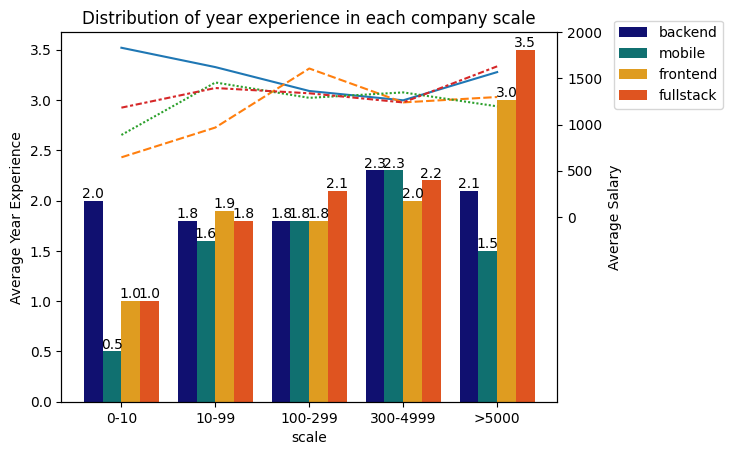

In [234]:
## VIsualize the comparison between year experience and salary in each dev sub group
ax = sns.barplot(x='employer_scale_new_group',y='year_experience_new',
                 palette=dev_color,
                 order = ['0-10','10-99', '100-299', '300-4999', '>5000'],hue ='sub_group',data = level_exp_scale_dev)
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f')

plt.xlabel('scale')
plt.ylabel('Average Year Experience')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Distribution of year experience in each company scale')

ax4 = ax.twinx()
sns.lineplot(x='employer_scale_new_group',y='salary_average',hue ='sub_group',style='sub_group',data = level_exp_scale_dev,ax=ax4)
plt.ylim(-2000)
ticks = [tick for tick in plt.gca().get_yticks() if tick >=0]
ax4.get_legend().remove()
plt.gca().set_yticks(ticks)
plt.ylabel('Average Salary')

Text(0.5, 1.0, 'Distribution of year experience in each company scale')

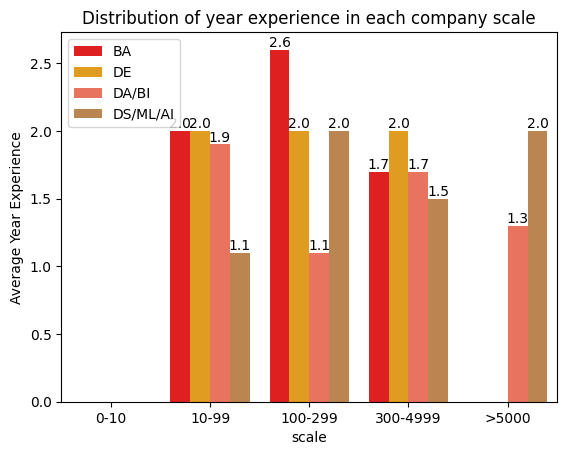

In [190]:
## VIsualize the comparison between year experience and salary in each data sub group
ax = sns.barplot(x='employer_scale_new_group',y='year_experience_new',
                 palette = data_color,
                 order = ['0-10','10-99', '100-299', '300-4999', '>5000'],hue ='sub_group',data = level_exp_scale_data)
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f')

plt.legend(loc = 'upper left')
plt.xlabel('scale')
plt.ylabel('Average Year Experience')
plt.title('Distribution of year experience in each company scale')

### Exp X location

In [133]:
## Calculate the average year experience per level in each location for each sub group
the_group_level_exp_lo = level_exp_df\
.groupby(["level",'sub_group','New_location'])\
.agg({'year_experience_new':'mean'})\
.reset_index()
the_group_level_exp_lo['year_experience_new'] = the_group_level_exp_lo['year_experience_new'].apply(lambda x: round(x,1))

In [134]:
## Sort the display in visualization backend, mobile, frontend, and fullstack
sorter_dev = ['backend', 'mobile','frontend', 'fullstack']
the_group_level_exp_lo_dev = the_group_level_exp_lo[the_group_level_exp_lo['sub_group'].isin(['backend', 'mobile','frontend', 'fullstack'])]\
    .sort_values(by = 'sub_group',key=lambda column: column.map(lambda e: sorter_dev.index(e)))

## Sort the display in visualization BA, DE, DA/BI, and DS/ML/AI
sorter_data = ['BA','DE', 'DA/BI','DS/ML/AI']
the_group_level_exp_lo_data = the_group_level_exp_lo[the_group_level_exp_lo['sub_group'].isin(['BA','DE', 'DA/BI','DS/ML/AI'])]\
    .sort_values(by = 'sub_group',key=lambda column: column.map(lambda e:sorter_data.index(e)))


Text(0.5, 1.0, 'Distribution of year experience in each location')

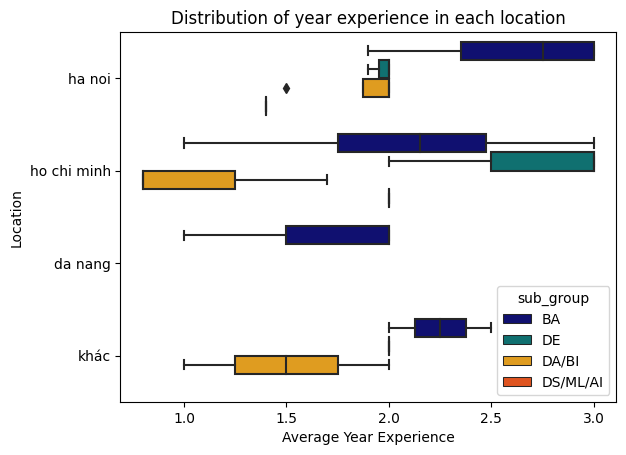

In [219]:
## VIsualize the salary distribution of each location in each dev sub group
ax = sns.boxplot(x='year_experience_new',y='New_location',
                 palette=data_color,
                 order = ['ha noi','ho chi minh','da nang','khác'],hue ='sub_group',data = the_group_level_exp_lo_data)

plt.xlabel('Average Year Experience')
plt.ylabel('Location')
plt.title('Distribution of year experience in each location')

Text(0.5, 1.0, 'Distribution of year experience in each location')

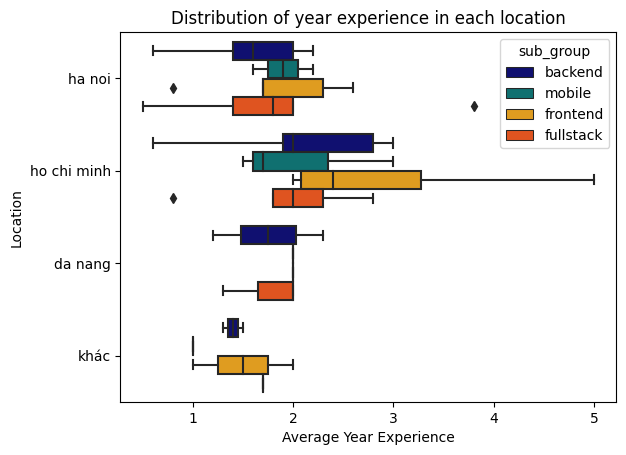

In [220]:
## Visualize the salary distribution of each location in each data sub group
ax = sns.boxplot(x='year_experience_new',y='New_location',
                 palette=dev_color,
                 order = ['ha noi','ho chi minh','da nang','khác'],hue ='sub_group',data = the_group_level_exp_lo_dev)

plt.xlabel('Average Year Experience')
plt.ylabel('Location')
plt.title('Distribution of year experience in each location')

### Sal X Exp

In [137]:
## Calculate the average of year experience and salary per each level in each sub group
the_group_level_exp = level_exp_df\
.groupby(["level",'sub_group'])\
.agg({'year_experience_new':'mean',
      'salary_average':'mean'})\
.reset_index()

In [138]:
## Sort the display in visualization of level from the smallest to the highest
sorter = ["fresher","junior",'general staff','senior','leader']
the_group_level_exp.sort_values(by="level", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)

In [139]:
## Detach the dataset into dev and data dataset
the_group_level_exp_dev = the_group_level_exp[the_group_level_exp['sub_group'].isin(['mobile','fullstack','frontend','backend'])]
the_group_level_exp_data = the_group_level_exp[~(the_group_level_exp['sub_group'].isin(['mobile','fullstack','frontend','backend']))]

In [140]:
## Adding missing group in level
for i in set(the_group_level_exp_dev['sub_group']):
    test = the_group_level_exp_dev[the_group_level_exp_dev['sub_group'] == i]
    for n in ["fresher","junior",'general staff','senior','leader']:
        if n not in list(set(test['level'])):
                new_row = {'level':n,'sub_group':i, 'year_experience_new':0, 'salary_average':0}
                the_group_level_exp_dev = the_group_level_exp_dev.append(new_row, ignore_index=True)


for i in set(the_group_level_exp_data['sub_group']):
    test = the_group_level_exp_data[the_group_level_exp_data['sub_group'] == i]
    for n in ["fresher","junior",'general staff','senior','leader']:
        if n not in list(set(test['level'])):
                new_row = {'level':n,'sub_group':i, 'year_experience_new':0, 'salary_average':0}
                the_group_level_exp_data = the_group_level_exp_data.append(new_row, ignore_index=True)



Text(0, 0.5, 'Average Salary')

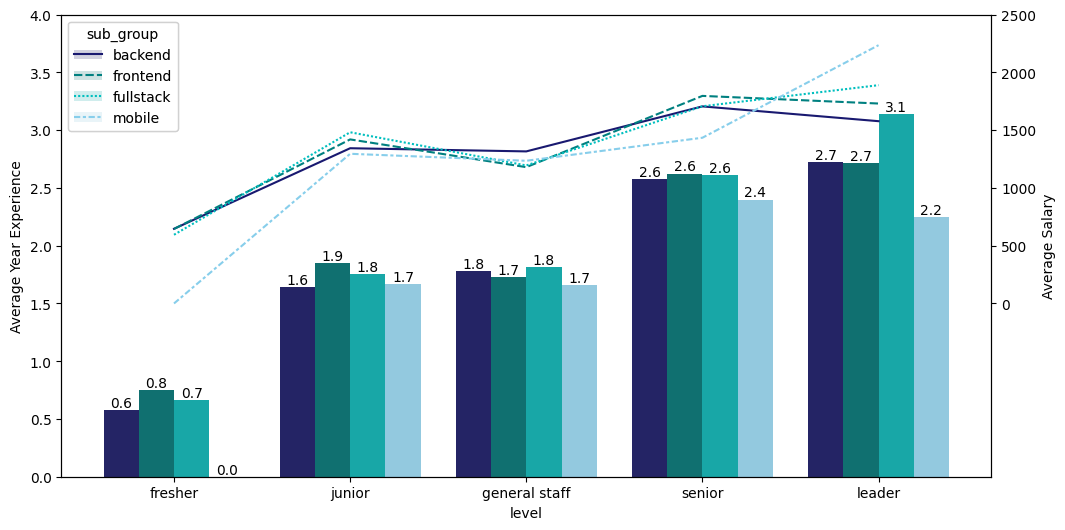

In [193]:
## Visualize the salary and year experience distribution per each level in dev sub group
fig, ax3 = plt.subplots(figsize=(12,6))

sns.barplot(x='level',y='year_experience_new',
            palette=dev_color,hue ='sub_group',data = the_group_level_exp_dev,ax=ax3)
plt.ylim(0,4)
for i in ax3.containers:
    ax3.bar_label(i, fmt='%.1f')
plt.ylabel('Average Year Experience')

ax4 = ax3.twinx()
sns.lineplot(x='level',y='salary_average',
             palette=dev_color,
             hue ='sub_group',style='sub_group',data = the_group_level_exp_dev,ax=ax4)
plt.ylim(-1500)
ticks = [tick for tick in plt.gca().get_yticks() if tick >=0]
plt.gca().set_yticks(ticks)
plt.ylabel('Average Salary')

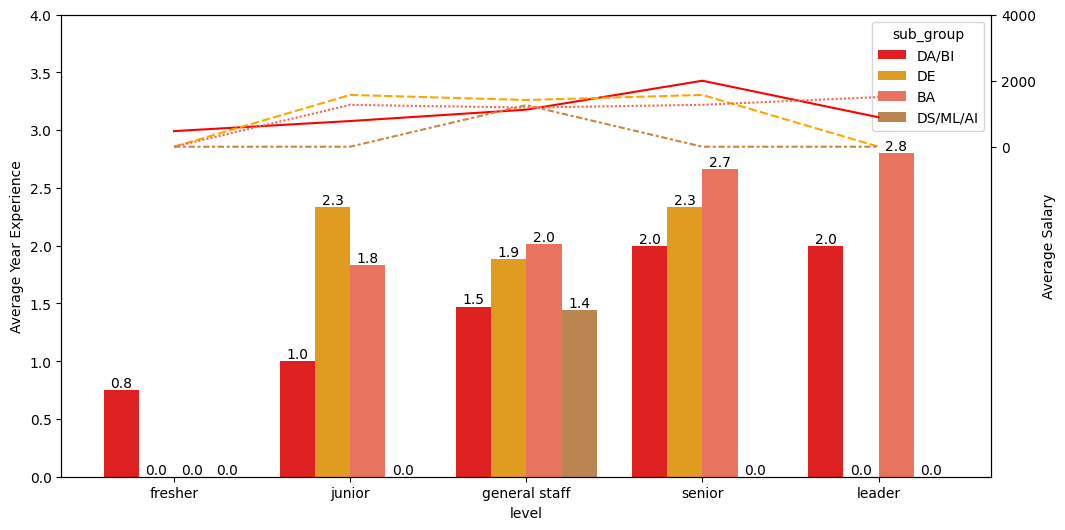

In [194]:
## Visualize the salary and year experience distribution per each level in data sub group
fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(x='level',y='year_experience_new',
            palette=data_color,
            hue ='sub_group',data = the_group_level_exp_data,ax=ax1)
plt.ylim(0,4)
for i in ax1.containers:
    ax1.bar_label(i, fmt='%.1f')
plt.ylabel('Average Year Experience')

ax2 = ax1.twinx()
sns.lineplot(x='level',y='salary_average',
             palette=data_color,
             hue ='sub_group',style='sub_group',data = the_group_level_exp_data,ax=ax2)
plt.ylim(-10000)
ticks = [tick for tick in plt.gca().get_yticks() if tick >=0]
plt.gca().set_yticks(ticks)
plt.ylabel('Average Salary')
plt.legend().set_visible(False)



##### Draft

In [143]:
# the_group_level_exp = the_group_level_exp[~(the_group_level_exp['level'].isin(['all level','unknown']))].fillna(0)
# the_group_level_exp['year_experience_min'] = the_group_level_exp['year_experience_new']['mean'] - the_group_level_exp['year_experience_new']['std']
# the_group_level_exp['year_experience_max'] = the_group_level_exp['year_experience_new']['mean'] + the_group_level_exp['year_experience_new']['std']
# the_group_level_exp

In [144]:
# for i in list(set(the_group_level_exp["sub_group"])):
#         to_chart = the_group_level_exp[(the_group_level_exp.sub_group == i)]
#         ax = sns.barplot(x='year_experience_new', y='level',
#             order = ['fresher','junior','senior','team leader','head of department'],data=to_chart)
#         for n in ax.containers:
#                 ax.bar_label(n,)
#         plt.title("The mean year experience per level of " + i + " position")
#         plt.xlabel('Average year experience')
#         plt.ylabel('level')
#         plt.show()

## 7/ Year_experience

##### General

In [145]:
## Selected neccesary columns
exp = job_df[["id","year_experience","sub_group"]]

In [146]:
## Split the year experience into row (because some posts can contai many different year experience for 1 position)
exp.year_experience = exp.year_experience.str.split(',')                                                               
exp = exp.explode('year_experience')

In [147]:
## Relabled any year experiences under 1 years into under 1 year
exp["year_experience_new"] = np.where(exp["year_experience"].isin(['03 month','06 month']),'under 1 year',
                                      exp["year_experience"])

##### Draft

In [148]:
# for i in list(set(exp["sub_group"])):
#         if i is not np.NaN:
#                 to_chart = exp[(exp.sub_group == i)]
#                 to_chart_agg = to_chart['year_experience_new']\
#                         .value_counts()\
#                         .to_frame()\
#                         .reset_index()\
#                         .rename({'index':'exp','year_experience_new':'counting'},axis = 1)
#                 ax = sns.barplot(x='counting',y = 'exp',data = to_chart_agg, order = ["under 1 year","1 year","2 year","3 year","4 year","5 year","6 year","7 year","all levels"])
#                 for n in ax.containers:
#                         ax.bar_label(n,)
#                 plt.title("Number of post per loction of " + i + " poisition")
#                 plt.xlabel('percent (%)')
#                 plt.ylabel('skills')
#                 plt.show()

In [149]:
# ## Step 5: visualize the number of value inside each group
# ## Calculate number of data in each group
# exp_group_cout = pd.DataFrame(exp[["year_experience","job_group"]].value_counts().reset_index())
# exp_group_cout.rename(columns = {'index':'group','year_experience':'counting'}, inplace = True)

In [150]:
# def fill_number(col):   
#     if col == "06 month":
#         return 0.5
#     else: return col[:1]

In [151]:
# exp_group_cout["exp_year"] = exp_group_cout["counting"].apply(lambda x: fill_number(x))
# exp_group_cout["exp_year"] = exp_group_cout["exp_year"].apply(lambda x: float(x))
# exp_group_cout["multiply"] = (exp_group_cout["exp_year"]*exp_group_cout[0])/np.sum(exp_group_cout["exp_year"])
# exp_group_cout["multiply"].head(6).mean()


In [152]:
# ## reorder the position of each group
# t = pd.CategoricalDtype(categories=["03 month","06 month","1 year","2 year","3 year","4 year","5 year","over 10 year"], ordered=True)
# exp_group_cout['group'] = pd.Series(exp_group_cout.group, dtype=t)
# exp_group_cout.sort_values(by=['group'], inplace=True)

In [153]:
## plotting the chart
# exp_graph = exp_group_cout.set_index("group").plot(kind='bar',
#                                     figsize=(14,8),
#                                     title="Number of post for each level")
# exp_graph.set_xlabel("Level")
# exp_graph.set_ylabel("Frequency")

## 8/ Employer_domain

In [154]:
## Extract neccessary columns from the original dataset
domain = job_df[["id","employer_domain",'sub_group','employer_scale_new_group']]

In [155]:
## Detach the employee domain into each rows
domain.employer_domain = domain.employer_domain.str.split(',')                                                               
domain = domain.explode('employer_domain')

In [156]:
## Replaced irrelevant words
to_replace_domain = {'computer software':'software','it-hardware':'hardware'}
domain["employer_domain"] = domain["employer_domain"].apply(lambda x: replace_all(x,to_replace_domain))

In [157]:
## Counting the number of employer domain for each sub group
to_chart_domain = domain[["employer_domain",'sub_group']]\
    .value_counts()\
    .to_frame()\
    .reset_index()\
    .rename({0:'counting'},axis = 1)
to_chart_domain = to_chart_domain[to_chart_domain.employer_domain != 'in']


DA/BI


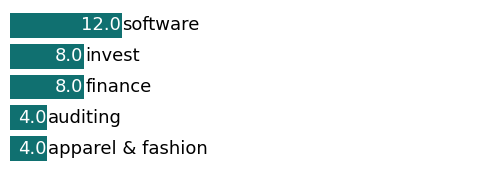

frontend


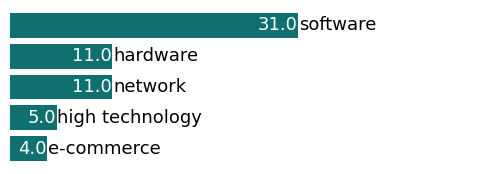

BA


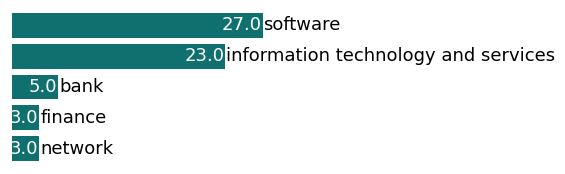

backend


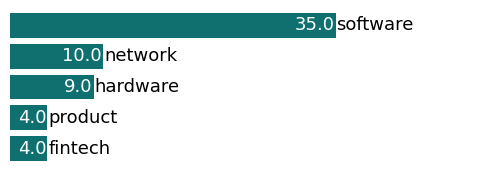

DE


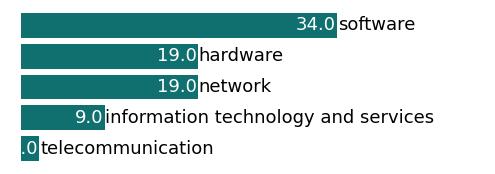

DS/ML/AI


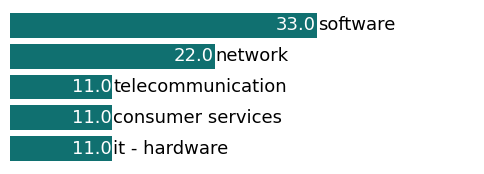

fullstack


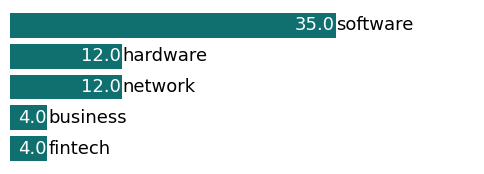

mobile


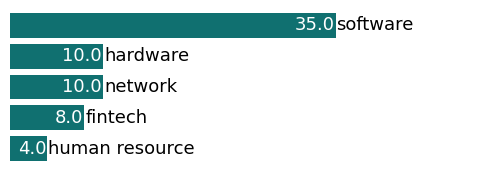

In [218]:
## Visualize Top 5 skillsets needed for each sub group
for i in list(set(to_chart_domain["sub_group"])):
        to_chart = to_chart_domain[(to_chart_domain.sub_group == i)]
        to_chart["percentage"] = round((to_chart["counting"]/sum(to_chart["counting"]))*100,0)
        to_chart = to_chart.sort_values("percentage",ascending=False).head(5)

        plt.figure(figsize=(6, 2))
        ax = sns.barplot(x='percentage',y = 'employer_domain',data = to_chart,color='teal')
        # for n in ax.containers:
        #         ax.bar_label(n,)
        for index, value in enumerate(round(to_chart['percentage'],2)):
                plt.text(value-0.1, index, str(value),ha = 'right',va = 'center',color='white',fontsize = 13)
    
        old_ticks = ax.get_yticks()
        for n in range(len(old_ticks)):
                plt.text(list(to_chart['percentage'])[n]+0.1, n , list(to_chart['employer_domain'])[n], ha = 'left', va = 'center', color = 'black', fontsize = 13)

        print(i)
        # plt.xlabel('percent (%)')
        # plt.ylabel('domains')
        plt.xlim(0,50)
        plt.margins(x=0.005)
        plt.axis('off')
        plt.show()

#### domain_scale

In [159]:
## Restructure dataset and calculate the number of each domain scale for each sub group
domain['domain_scale'] = domain['employer_domain'] + " " + domain['employer_scale_new_group']
domain_no_in = domain[domain.employer_domain != 'in']
to_chart_domain_scale = domain_no_in[["domain_scale",'sub_group']]\
    .value_counts()\
    .to_frame()\
    .reset_index()\
    .rename({0:'counting'},axis = 1)

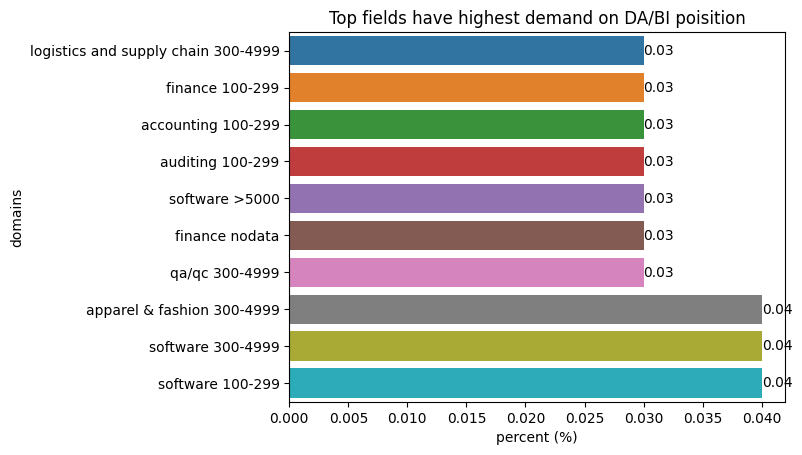

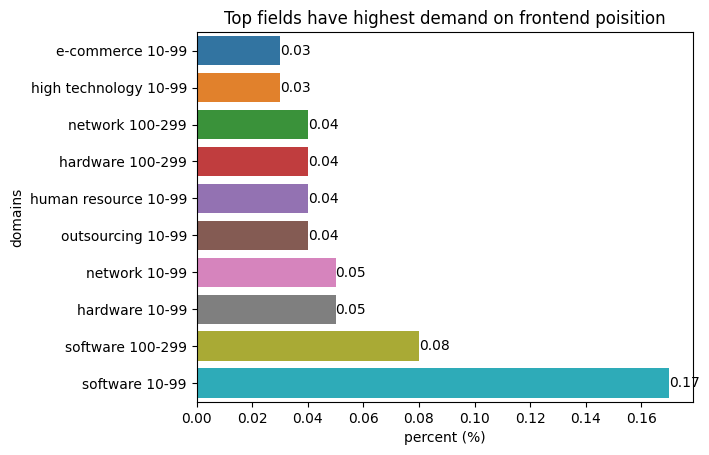

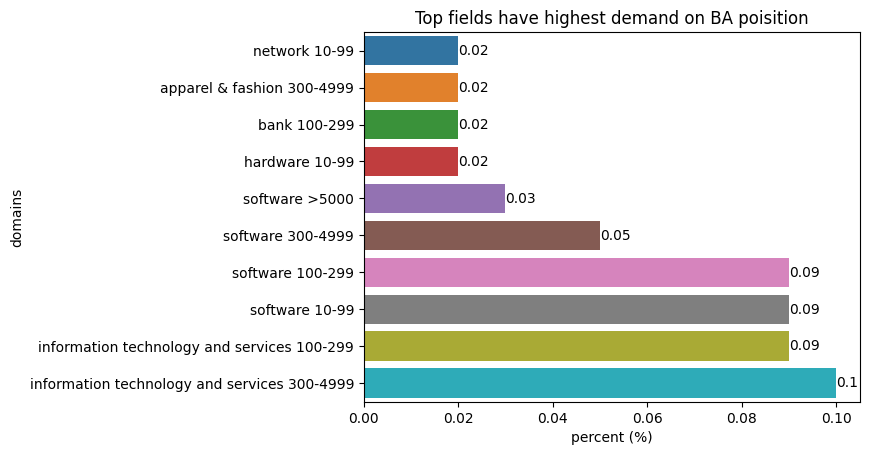

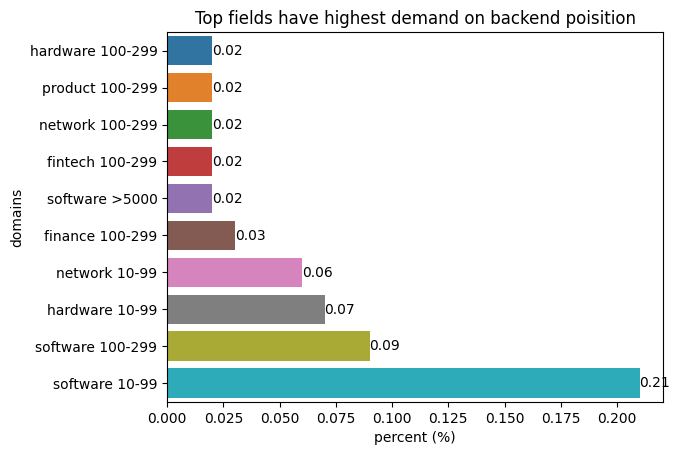

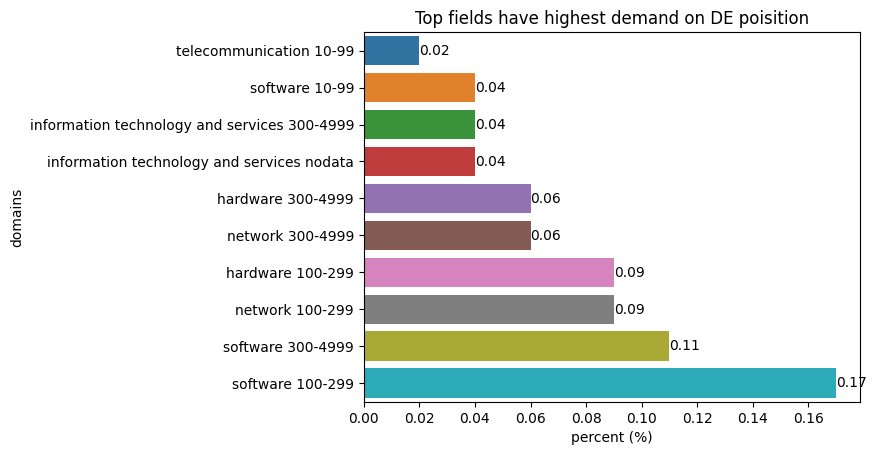

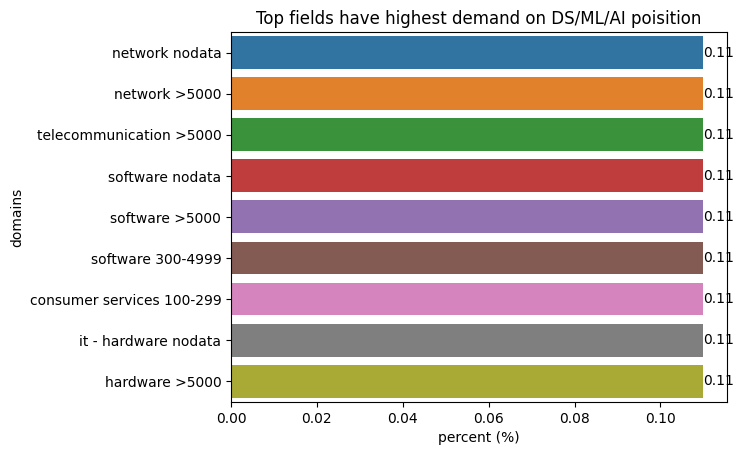

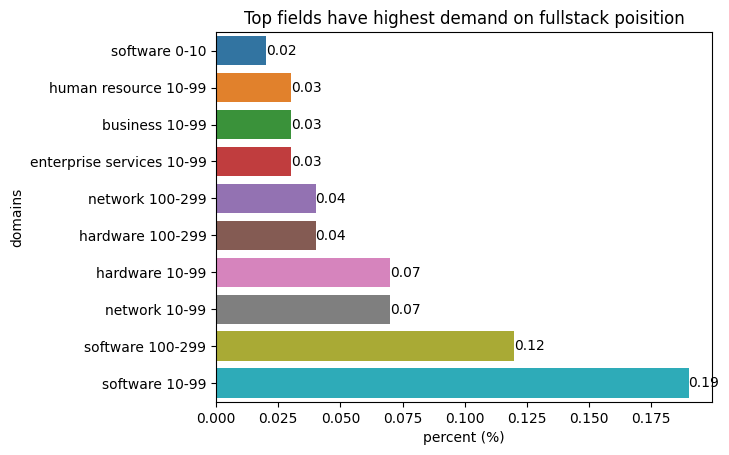

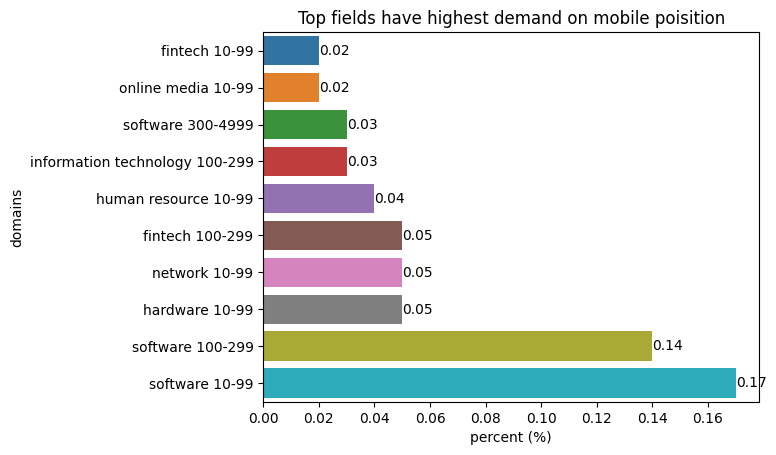

In [160]:
### Visualization
for i in list(set(to_chart_domain_scale["sub_group"])):
        to_chart = to_chart_domain_scale[(to_chart_domain_scale.sub_group == i)]
        to_chart["percentage"] = round(to_chart["counting"]/sum(to_chart["counting"]),2)
        to_chart = to_chart.sort_values("percentage",ascending=True).tail(10)
        ax = sns.barplot(x='percentage',y = 'domain_scale',data = to_chart)
        for n in ax.containers:
                ax.bar_label(n,)
        plt.title("Top fields have highest demand on " + i + " poisition")
        plt.xlabel('percent (%)')
        plt.ylabel('domains')
        plt.show()

## 9/ Employer_scale (Draft)

In [161]:
# ## Calculate number of data in each group
# scale_group_cout = pd.DataFrame(job_df["employer_scale_new_group"].value_counts().reset_index())
# scale_group_cout.rename(columns = {'index':'group','New_group':'counting'}, inplace = True)

In [162]:
# ## reorder the position of each group
# t = pd.CategoricalDtype(categories=["0-10","10-99","100-299","300-4999",">5000"], ordered=True)
# scale_group_cout['group'] = pd.Series(scale_group_cout.group, dtype=t)
# scale_group_cout.sort_values(by=['group'], inplace=True)

In [163]:
# ## Step 5: visualize the number of value inside each group
# scale_graph = scale_group_cout[~(scale_group_cout["employer_scale_new_group"] == "nan")].set_index("group").plot(kind='bar',
#                                     figsize=(8,8),
#                                     title="Number of post for each level")
# scale_graph.set_xlabel("Level")
# scale_graph.set_ylabel("Frequency")

## 10/ Country (Draft)

In [164]:
# ## Step 2: filter out nan
# country_df = country_df[~(country_df["country"].isin(["nan","Vietnam"]))]

In [165]:
# ## Step 3: regroup country - number of counts < 1
# country_to_other = ["China","New Zealand","Finland","United Arab Emirates","Sweden","Norway"]
# country_df["country_new"] = np.where(country_df["country"].isin(country_to_other),"Others",country_df["country"])

In [166]:
# ## Step 3: visualize the number of value inside each group
# country_count = country_df["country_new"].value_counts().reset_index()

# names = list(country_count["index"])
# count = list(country_count["country_new"])

# squarify.plot(sizes=count, label=names, bar_kwargs={'alpha':1}, text_kwargs={'fontsize':10} )
# plt.show()

In [167]:
# # Draw treemap chart with this column
# country_graph = country_df["country"].value_counts().dropna().plot(kind='bar',
#                                     figsize=(14,8),
#                                     title="Number of post for each level")
# country_graph.set_xlabel("Level")
# country_graph.set_ylabel("Frequency")

## 11/ Portal

In [168]:
## Extract neccessary columns from the original dataset
portal_df = job_df[["id","portal",'sub_group']]

number of post per portal by DA/BI position


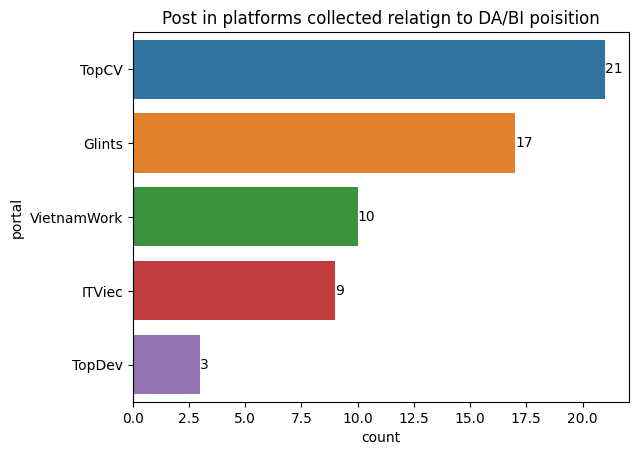

number of post per portal by frontend position


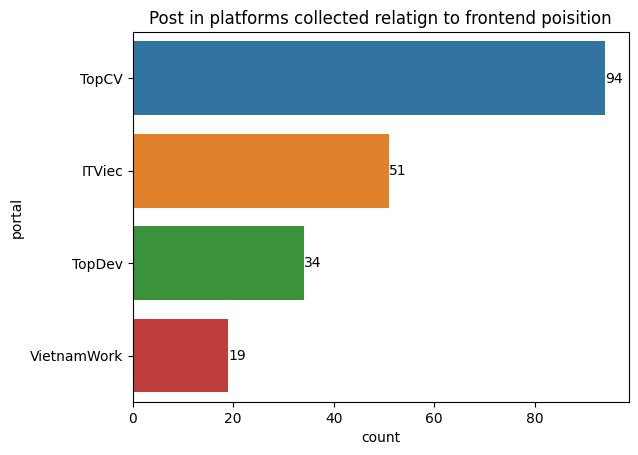

number of post per portal by BA position


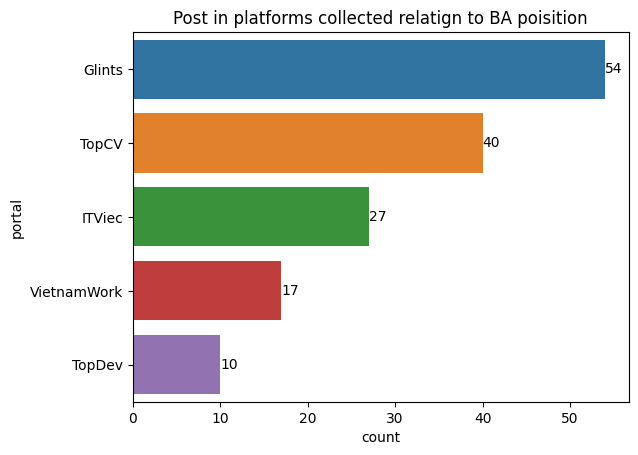

number of post per portal by backend position


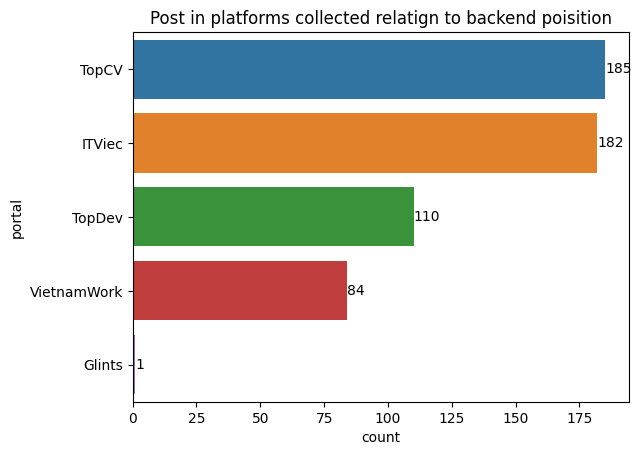

number of post per portal by DE position


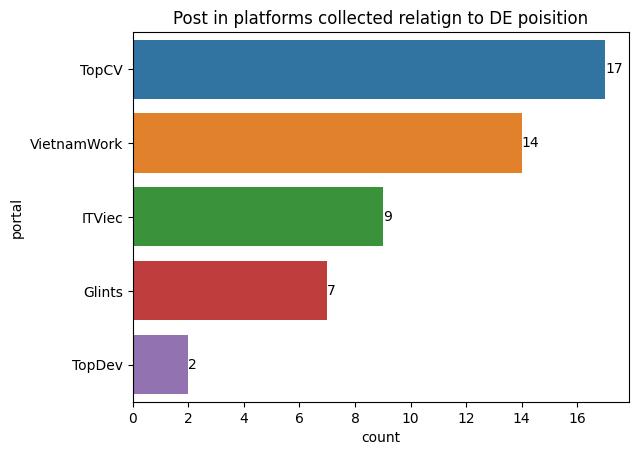

number of post per portal by DS/ML/AI position


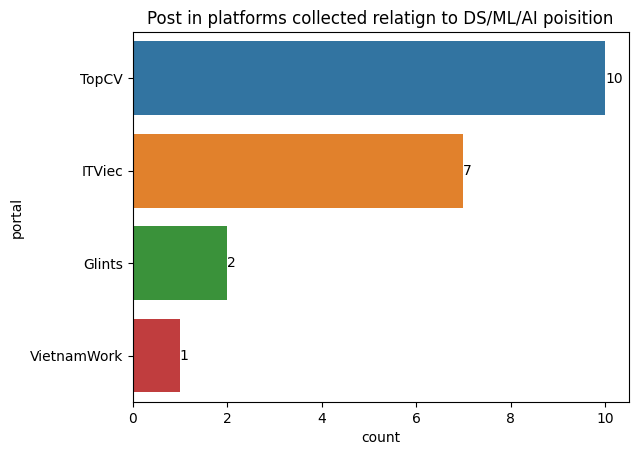

number of post per portal by fullstack position


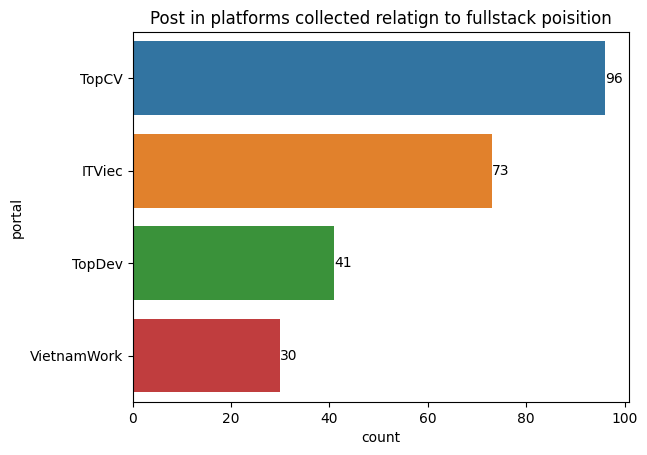

number of post per portal by mobile position


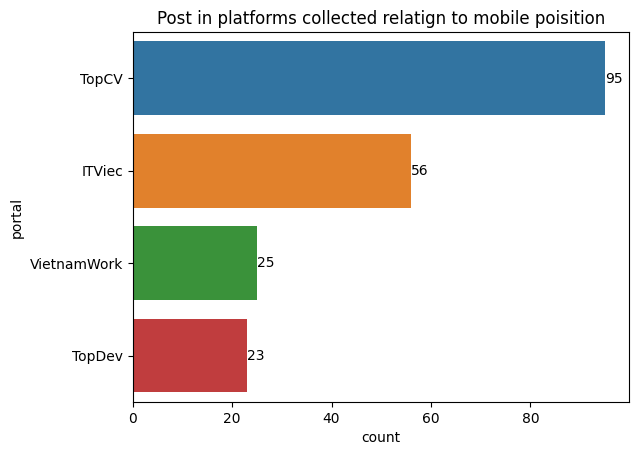

In [169]:
### Visualization
for i in list(set(portal_df['sub_group'])):
    if i is not np.NaN:
        print('number of post per portal by '+ i + ' position')
        to_see = portal_df[portal_df['sub_group'] == i]
        to_see = to_see["portal"]\
            .value_counts()\
            .dropna()\
            .to_frame()\
            .reset_index()\
            .rename({'index':'portal','portal':'counting'},axis = 1)
        ax = sns.barplot(x='counting',y = 'portal',data = to_see)
        for n in ax.containers:
                        ax.bar_label(n,)
        plt.title("Post in platforms collected relatign to " + i + " poisition")
        plt.xlabel('count')
        plt.ylabel('portal')
        plt.show()

In [170]:
# ## Step 1: visualize the number of value inside each group
# portal_graph = portal_df["portal"].value_counts().dropna().plot(kind='bar',
#                                     figsize=(10,4),
#                                     title="Number of post for each job portal")
# portal_graph.set_xlabel("Portal")
# portal_graph.set_ylabel("Frequency")

## 12/Title_final

In [171]:
## Extract neccessary columns from the original dataset
title_df = job_df[["id","title_final",'sub_group']]


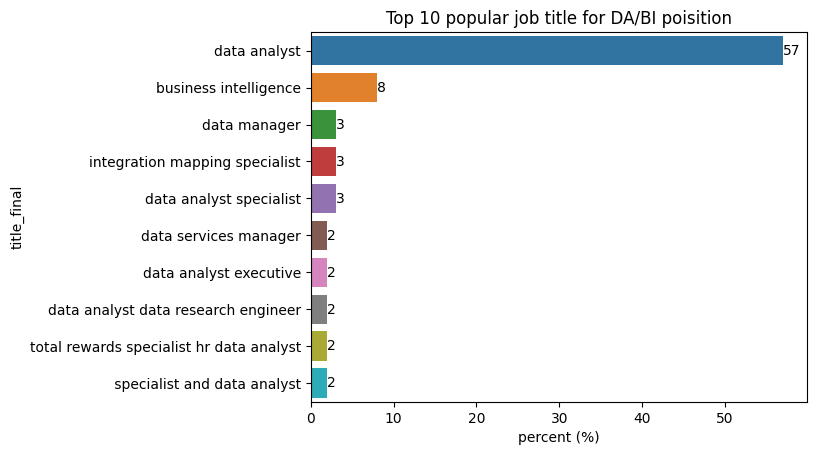

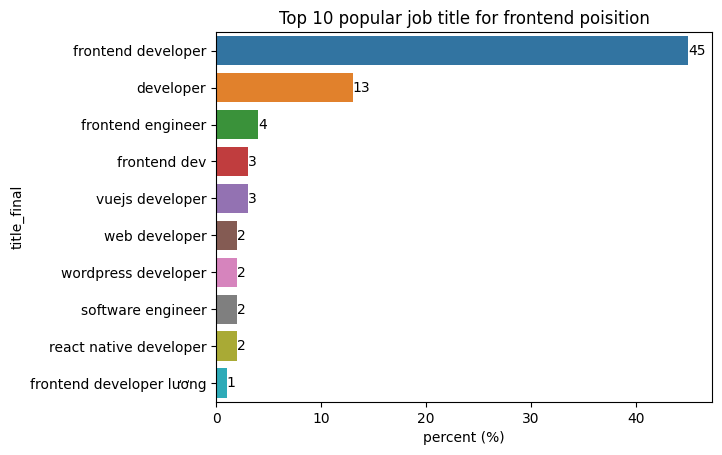

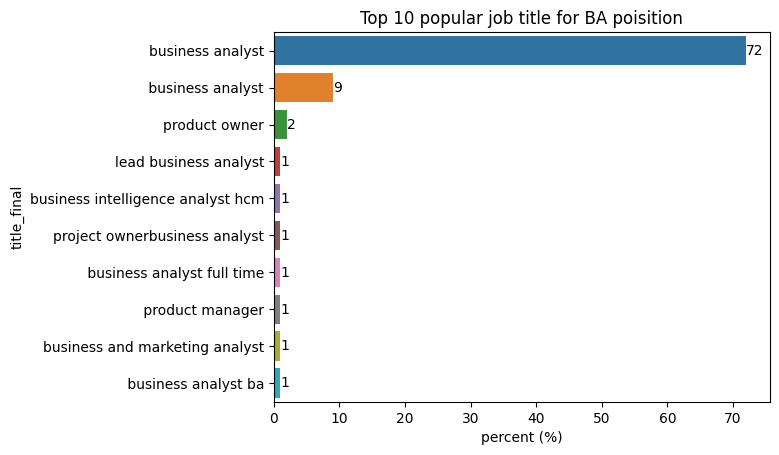

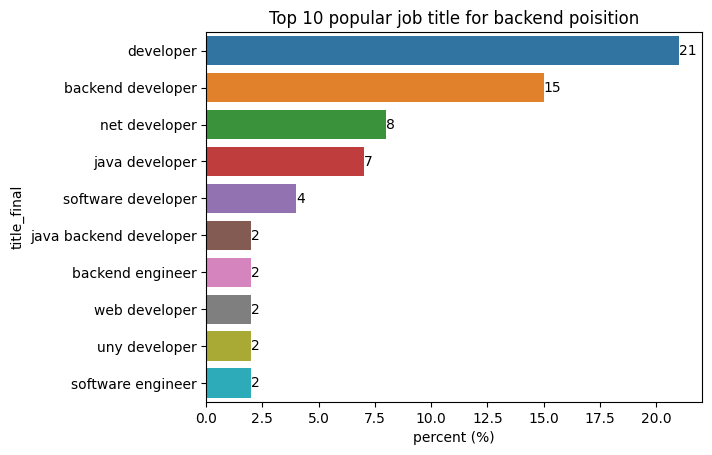

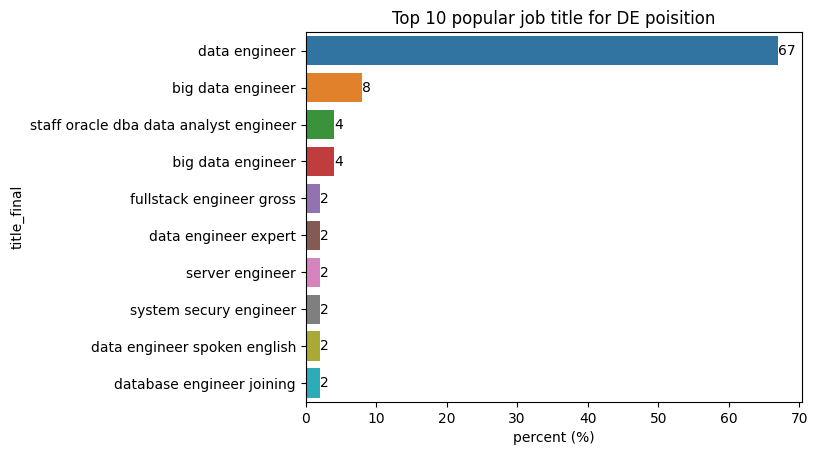

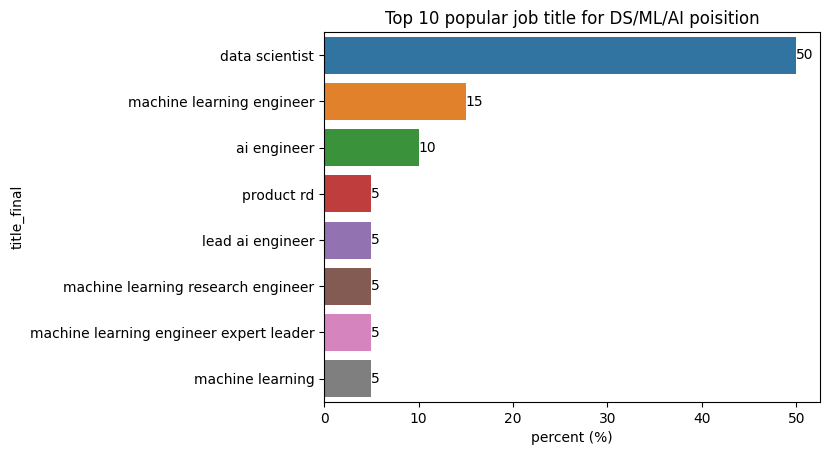

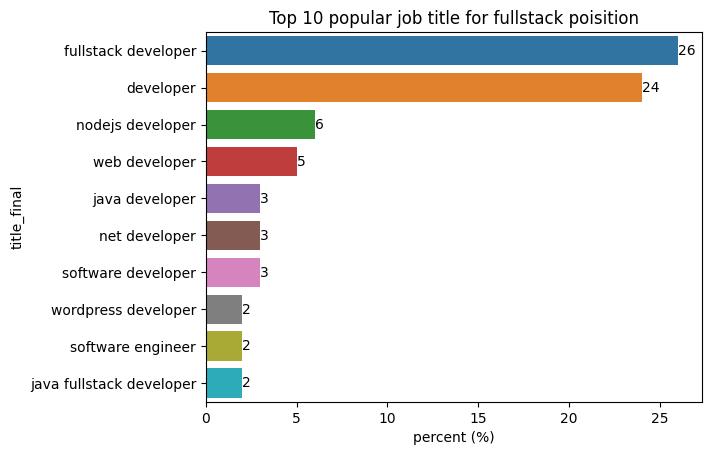

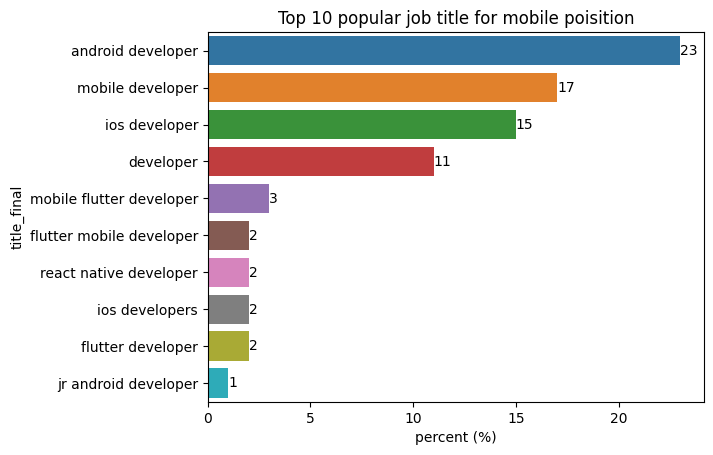

In [172]:
### Visualization
for i in list(set(title_df['sub_group'])):
    if i is not np.NaN:
        to_see = title_df[title_df['sub_group'] == i]
        to_see = to_see["title_final"]\
            .value_counts()\
            .to_frame()\
            .reset_index()\
            .rename({'index':'title_final','title_final':'counting'},axis = 1)
        to_see["percentage"] = round(to_see["counting"]/sum(to_see["counting"]),2)*100
        to_see = to_see.sort_values("percentage",ascending=False).head(10)
        ax = sns.barplot(x='percentage',y = 'title_final',data = to_see)
        for n in ax.containers:
                        ax.bar_label(n,)
        plt.title("Top 10 popular job title for " + i + " poisition")
        plt.xlabel('percent (%)')
        plt.ylabel('title_final')
        plt.show()

##### Draft

In [173]:
## Draw stacked bar char
# ## Step 2-b:the number of post in each portal per day
# cross_tab_prop = pd.crosstab(index=date_df['post_date'],columns=date_df['portal'],normalize="index")
# ## Visualize the result
# ax = cross_tab_prop.plot(kind ='bar',stacked=True,colormap='tab10',figsize=(20,10))
# ax.set_xticklabels([x.strftime("%Y-%m-%d") for x in cross_tab_prop.index])
# plt.legend(loc="upper left", ncol = 3)
# plt.xlabel("post_date")
# plt.ylabel("Proportion")